<a href="https://colab.research.google.com/github/rampopat/uncertainty/blob/main/Main_Notebook_DementiaBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Notebook - DementiaBank

This notebook contains the main code of the thesis. It includes the data pipeline, the Bayesian Deep Learning models and experiments, and the Active Learning implementation and execution for the DementiaBank dataset.

The notebook is organised into a markdown section hierarchy and the sections are named informatively. Broadly, we begin with the imports, the data pipeline and some core functions and classes. We then have three main sections: RNNs, Bayesian RNNs and Transformer. Within each of these, they are divided into: Core Classes and Functions, Single Run, Cross Validation, Deep Ensemble, Monte Carlo Dropout, Active Learning (and also model variants e.g. the sentence and text level for the transformer).

Here is the Table of Contents.

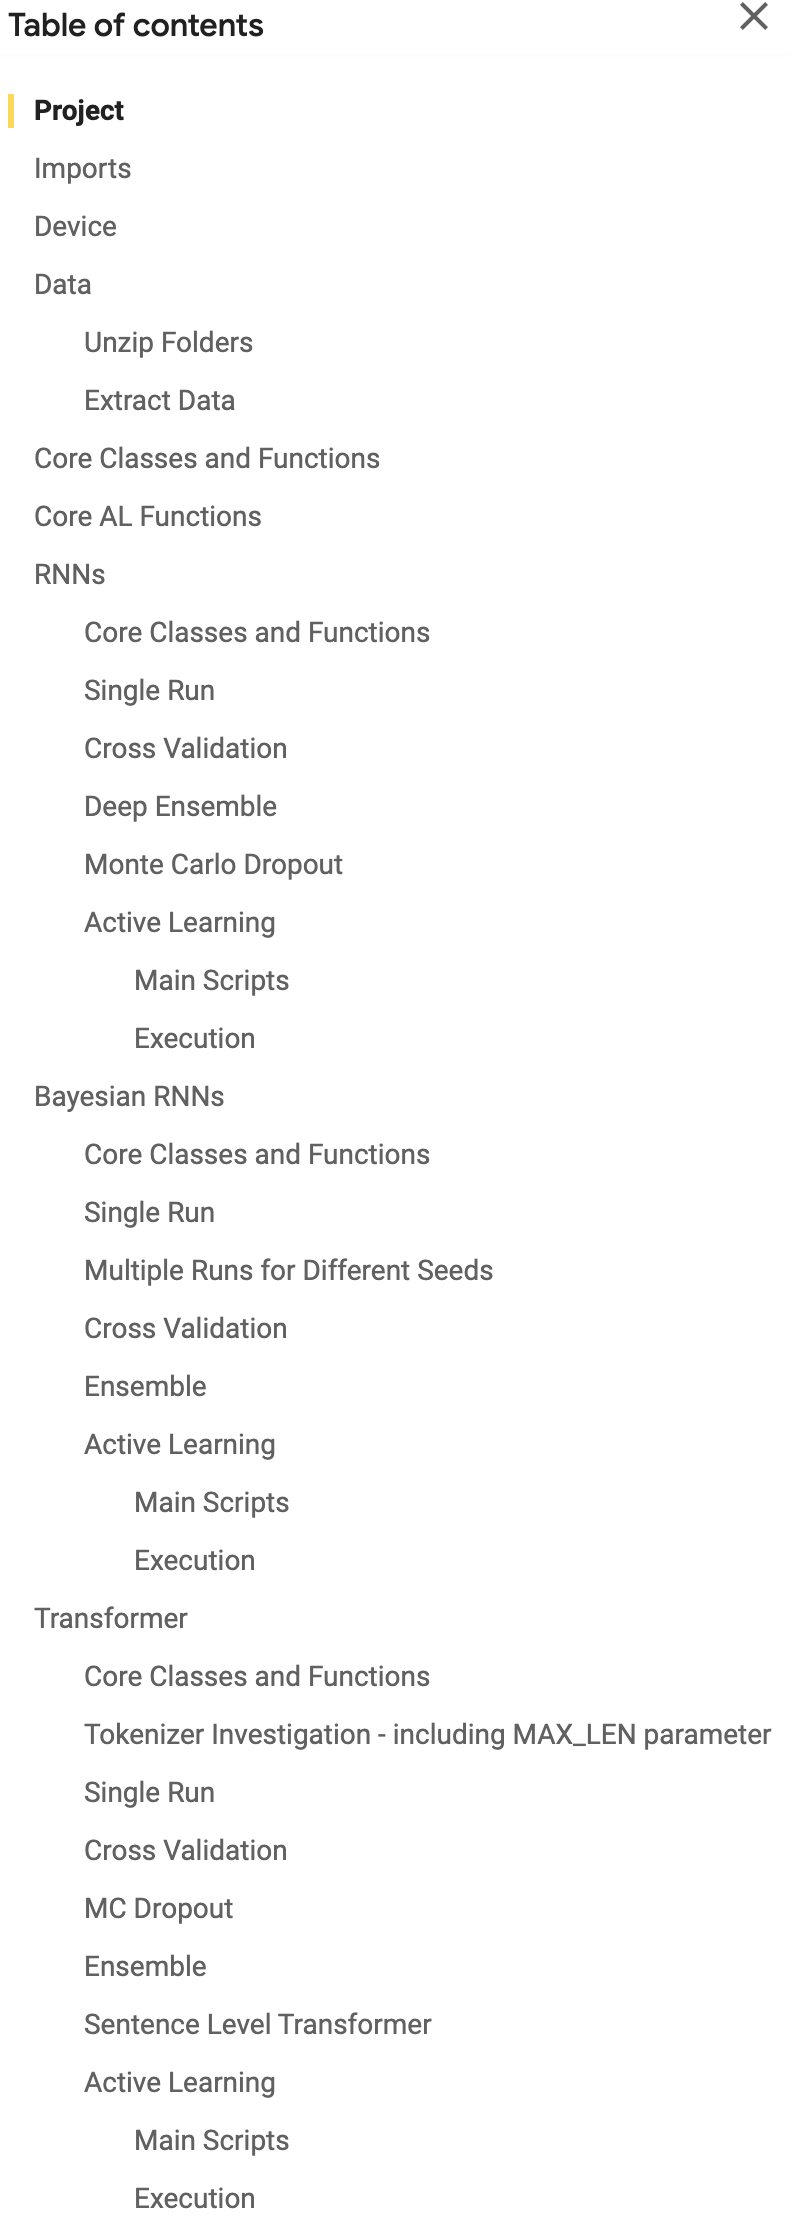

# Imports

In [ ]:
!pip install pylangacq
!pip install contractions
import pylangacq as pl
import re
import contractions
import codecs
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import time
from enum import Enum
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, plot_roc_curve, plot_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
import sys
!pip install transformers
!pip install sentencepiece
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [ ]:
! pip install pyro-ppl
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoLowRankMultivariateNormal
from pyro.nn.module import PyroModule, PyroParam, PyroSample, clear, to_pyro_module_
from pyro import poutine
from torch.distributions import constraints
assert pyro.__version__.startswith('1.6.0')

In [ ]:
!pip install baal

In [ ]:
from baal.active import ActiveLearningDataset
import baal.active.heuristics
import copy
from scipy.stats import entropy

In [ ]:
%config InlineBackend.figure_format = 'retina'
%load_ext google.colab.data_table

# Device

In [ ]:
!nvidia-smi -L
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

def printm():
    GPUs = GPU.getGPUs()
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print('process id', process)
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [ ]:
# Get device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")    

In [ ]:
PATH_TO_SAVED_MODELS = 'drive/MyDrive/ProjectModels/'

# Data 

### Unzip Folders

In [ ]:
! unzip drive/MyDrive/Pitt.zip
! unzip drive/MyDrive/glove.6B.zip

## Extract Data

In [ ]:
## Common to both transformers and RNNs ## 

def get_chat_files_labels():
    #  Read ordered chat files from txt file into a list
    with open("drive/MyDrive/ChatFilesList.txt", "r") as cfl:
        lines = cfl.readlines()
    chat_files = [re.sub('\n', '', line) for line in lines]

    #  Extract series of values corresponding to dementia or not based one which folder the transcript comes from
    #  i.e. 1 for Dementia, 0 for HC
    labels = []
    for file in chat_files:
        label = 0
        if 'Dementia' in file:
            label = 1
        labels.append(label)

    def print_missing_files():
        # Should print nothing
        for file in chat_files:
            if not os.path.isfile(file):
                print(file)

    return chat_files, labels

chat_files, full_labels = get_chat_files_labels()

dementia = pl.Reader.from_files(chat_files)

## For Transformers ##
transcripts = [dementia[idx].words('PAR') for idx in range(dementia.n_files())]
transcripts = list(map(lambda x: " ".join(x), transcripts))

## For RNNs ##
def get_data_for_rnns(dementia, embedding_dim):
    transcripts_before_processing = [dementia[idx].words('PAR') for idx in range(dementia.n_files())]

    all_transcripts = []

    for transcript in transcripts_before_processing:
        #  contraction correction
        transcript_processed = []
        for word in transcript:
            #  Remove underscores
            if '_' in word:
                word = word.replace('_', ' ')
            #  Everything should be lower case because glove embeddings are lowercase
            word = word.lower()
            #  Use extend because split returns array
            transcript_processed.extend(contractions.fix(word).split())
        all_transcripts.append(transcript_processed)


    def create_vocab(tokenized_corpus):
        vocabulary = []
        for sentence in tokenized_corpus:
            for token in sentence:
                if token not in vocabulary:
                    vocabulary.append(token)
        return set(vocabulary)


    vocab = create_vocab(all_transcripts)

    embeddings = []
    word2idx = []
    idx2word = []

    #  Get corresponding Glove file
    glove_file = 'glove.6B.{}d.txt'.format(embedding_dim)

    # glove file has each line as a space-separated string = word followed by
    #  its embedding
    with codecs.open(glove_file, 'r', 'utf-8') as f:
        embeddings.append([0] * embedding_dim)
        word2idx.append(('PAD', 0))
        idx2word.append((0, 'PAD'))
        idx = 1
        for line in f.readlines():
            line_vectorised = line.strip().split()
            word = line_vectorised[0]
            if word in vocab:
                # line_vectorised[1:] = list of strings of word's embedding,
                #  we convert this into a list of floats
                (word, vec) = (word, list(map(float, line_vectorised[1:])))
                embeddings.append(vec)
                word2idx.append((word, idx))
                idx2word.append((idx, word))
                idx += 1

    #  embeddings was list of lists of embeddings for each word in vocab
    embeddings = torch.tensor(embeddings)
    word2idx = dict(word2idx)
    idx2word = dict(idx2word)

    #  glove_vocab is the subset of the corpus vocab that have embeddings
    glove_vocab = set(word2idx.keys())

    vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in all_transcripts]
    tensorized_seqs = [torch.tensor(seq) for seq in vectorized_seqs]
    transcripts_emb_pad = pad_sequence(tensorized_seqs, batch_first=True)
    transcript_lengths = list(map(len, vectorized_seqs))
    return transcripts_emb_pad, transcript_lengths, embeddings

EMBEDDING_DIM = 100
transcripts_emb_pad, transcript_lengths, embeddings = get_data_for_rnns(dementia, EMBEDDING_DIM)
print(transcripts_emb_pad.numpy().shape)
print(np.array(full_labels).shape)
print(embeddings.shape)


# Core Classes and Functions

In [ ]:
np.set_printoptions(precision=4)

def set_seed(seed, set_pyro=False):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    if set_pyro:
        pyro.set_rng_seed(seed)

# Required for both RNNs and BRNNs
class DementiaDataRNN(Dataset):

    def __init__(self, data, lengths, labels):
        self.data = data
        self.lengths = lengths
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.lengths[index], self.labels[index]

def clf_report(preds, labels, printing=True):
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    if printing:
        print(f'Accuracy is {accuracy:.4f}')
        print(f'F1 score is {f1:.4f}')
        class_names = ['HC', 'AD']
        print(classification_report(labels, preds, target_names=class_names, digits=4))
        print('Confusion matrix is:')
        print(confusion_matrix(labels, preds))
    return accuracy, f1


def plot_loss_curves(num_epochs, train_losses, val_losses, val_accuracies):
    epochs = np.arange(num_epochs) + 1
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_losses, marker='.', label='Train Loss')
    plt.plot(epochs, val_losses, marker='.', label='Val Loss')
    plt.plot(epochs, val_accuracies, marker='.', label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss/Accuracy Curves')
    plt.legend()
    plt.show()

# Core AL Functions

In [ ]:
def get_entropy(ps):
    # ps is df series of the preds 
    # entropy(p) = -((1-p)log_2(1-p) + plog_2(p)) for p scalar,
    # we map this over the vector of probabilities
    # NOTE: WE CHANGED TO BASE E, TO ALLOW COMPARISON WITH BATCHBALD
    # IN PRINCIPLE THE BASE DOESN'T CHANGE THE RANKINGS
    return entropy(pk=np.stack([1-ps, ps]), axis=0)

def get_predictive_entropy(all_preds):
    # this is for convenience, so we can call all uncertainty metrics uniformly
    # all_preds.shape = (M, data_size)
    return get_entropy(all_preds.mean(axis=0))

def get_expected_entropy(all_preds):
    # all_preds.shape = (M = ensemble_size, data_size)
    ensemble_size = all_preds.shape[0]
    individual_entrops = np.array([get_entropy(all_preds[m]) for m in range(ensemble_size)])
    return individual_entrops.mean(axis=0)

def get_mutual_info(all_preds):
    # all_preds.shape = (M, data_size)
    # predictive_entropy.shape = (data_size,)
    predictive_entropy = get_entropy(all_preds.mean(axis=0))
    expected_entropy = get_expected_entropy(all_preds)
    return predictive_entropy - expected_entropy

def get_variation_ratio(all_preds, threshold=0.5):
    # all_preds.shape = (M, data_size)
    # ps, mean_preds, vrs shape = (data_size)
    data_size = all_preds.shape[1]
    ps = binarize(all_preds, threshold=threshold).mean(axis=0) # probability of dementia
    mean_preds = binarize(all_preds.mean(axis=0), threshold=threshold)
    vrs = [ps[i] if (mean_preds[i] == 0) else (1 - ps[i]) for i in range(data_size)]
    return vrs

def get_pred_var(all_preds):
    return all_preds.var(axis=0)

def get_batch_bald(all_preds, ndata_to_label, num_draw=5000):
    # this returns ranks not the uncertainty scores
    ps = all_preds.T # [ensemble_size, pool_size]  
    qs = np.stack([1-ps, ps], axis=1)
    return np.flip(baal.active.heuristics.BatchBALD(num_samples=ndata_to_label, num_draw=num_draw)(qs))[:ndata_to_label]

def binarize(ps, threshold=0.5):
    return np.where(ps > threshold, 1, 0)

# Performance 
def get_performance(metric, preds, labels):
    if metric == roc_auc_score:
        return roc_auc_score(labels, preds)
    return metric(labels, np.rint(preds))
    
def al_performance(active_test_preds, test_labels, train_sizes, best_epoch_performances=None, title='Active Learning', plotting=False):
    # for ensembles, active_test_preds is the mean across the ensemble, so we can use it for single model
    # active test preds should be un-rinted i.e. in (0, 1)
    PMETRIC_FNS = [accuracy_score, f1_score, roc_auc_score] # precision_score, recall_score]
    PMETRIC_NAMES = ['Accuracy', 'F1', 'ROC AUC'] #'Precision', 'Recall']
    al_steps = active_test_preds.shape[0]
    scores = np.zeros((len(PMETRIC_FNS), al_steps))
    for al_step in range(al_steps):
        preds = active_test_preds[al_step, :]
        for i, pmetric in enumerate(PMETRIC_FNS):
            scores[i, al_step] = get_performance(pmetric, preds, test_labels)

    if plotting:
        for i, name in enumerate(PMETRIC_NAMES):        
            plt.plot(train_sizes, scores[i, :], marker='.', label=name)
        # if best_epoch_performances is not None:
        #     plt.plot(train_sizes, best_epoch_performances, marker='.', label='ES Accuracy')
        plt.xlabel('Train Set Size')
        plt.ylabel('Performance')
        plt.title(title)
        plt.legend()
        plt.show()
    return scores

def compare_performances(al_list_preds, labels, train_sizes, baseline_preds=None, strategy_names=None, mask=None, 
                         is_ensemble=True):
    # make sure al_list_preds = input a list even if there is only one al_strategy
    PMETRIC_FNS = [accuracy_score, f1_score, roc_auc_score] # precision_score, recall_score]
    PMETRIC_NAMES = ['Accuracy', 'F1', 'ROC AUC'] #'Precision', 'Recall']
    # baseline_preds is a non-AL-based deep ensemble baseline that we will draw as a point on the graph
    # baseline_preds.shape = (ensemble_size, test_size)
    if baseline_preds is not None:
        baseline_preds = baseline_preds.mean(axis=0)
        baseline_scores = [get_performance(metric, baseline_preds, labels) for metric in PMETRIC_FNS]
    # mask is the subset of the data that we want
    if isinstance(al_list_preds, list):
        al_list_preds = np.array(al_list_preds)
    # al_list_preds is np array of ensembled preds by different strategies
    # al_list_preds.shape = (al_strategies, al_steps, ensemble_size, test_size)
    if strategy_names is None:
        strategy_names = [' '] * len(al_list_preds)
    if train_sizes is None:
        al_steps = al_list_preds.shape[1]
        train_sizes = np.linspace(0, 1, num=al_steps)
    # mean is over the ensemble_size because preds.shape = al_list_preds.shape[1:]
    if is_ensemble: # we set is_ensemble = False 
        al_list_preds = [preds.mean(axis=1) for preds in al_list_preds]
    list_scores = [al_performance(preds, labels, train_sizes) for preds in al_list_preds]
    
    rows = 1
    cols = len(PMETRIC_NAMES)
    plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    for i, name in enumerate(PMETRIC_NAMES):        
        plt.subplot(rows, cols, i + 1)
        for j, scores in enumerate(list_scores):
            if mask is None or j in mask:
                plt.plot(train_sizes, list_scores[j][i, :], marker='.', label=strategy_names[j])
        if baseline_preds is not None:
            plt.scatter(train_sizes[-1], baseline_scores[i], marker='^', label='Non-AL Baseline')
        plt.xlabel('Train Set Size')        
        plt.ylabel('Performance')
        plt.title(name)
        plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.savefig('al-comparison', dpi=350)
    plt.show()

def compare_performances_multiple_folds(mult_folds, labels, train_sizes, baseline_preds=None, strategy_names=None, mask=None, 
                         is_ensemble=True):
    PMETRIC_FNS = [accuracy_score, f1_score, roc_auc_score] # precision_score, recall_score]
    PMETRIC_NAMES = ['Accuracy', 'F1', 'ROC AUC'] #'Precision', 'Recall']
    if strategy_names is None:
        strategy_names = [' '] * len(al_list_preds)
    if train_sizes is None:
        al_steps = mult_folds[0].shape[1]
        train_sizes = np.linspace(0, 1, num=al_steps)
    list_scores = np.array([[al_performance(preds.mean(axis=1), labels[i], train_sizes) for preds in al_list_preds] for i, al_list_preds in enumerate(mult_folds)])
    # list_scores.shape = (num_folds, al_strategies, num_metrics, al_steps)
    list_scores = np.mean(list_scores, axis=0)
    rows = 1
    cols = len(PMETRIC_NAMES)
    plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    for i, name in enumerate(PMETRIC_NAMES):        
        plt.subplot(rows, cols, i + 1)
        for j, scores in enumerate(list_scores):
            if mask is None or j in mask:
                plt.plot(train_sizes, list_scores[j][i, :], marker='.', label=strategy_names[j])
        if baseline_preds is not None:
            plt.scatter(train_sizes[-1], baseline_preds[i], marker='^', label='Non-AL Baseline')
        plt.xlabel('Train Set Size')        
        plt.ylabel('Performance')
        plt.title(name)
        plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.savefig('al-comparison', dpi=350)
    plt.show()
    return list_scores

# RNNs



## Core Classes and Functions

In [ ]:
class RNNType(Enum):
    RNN = 1
    GRU = 2
    LSTM = 3


class MyRNN(nn.Module):

    def __init__(self, embeddings, embedding_dim, output_size, hidden_dim, rnn_layers, bidir, rnn_type, dropout):
        super(MyRNN, self).__init__()

        # embeddings.shape = (vocab_size/num_embeddings, embedding_dim)
        self.emb = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

        # PyTorch adds dropout to all but the last RNN layer in the RNN, so if rnn_layers = 1 and dropout > 0
        # the dropout will not be used and PyTorch will complain
        rnn_dropout = dropout
        if rnn_layers == 1 and dropout > 0:
            rnn_dropout = 0

        # RNN Layer. batch_first means inputs provided (batch, seq, feature) where feature refers to embedding dim
        if rnn_type is RNNType.RNN:
            self.rnn = nn.RNN(embedding_dim, hidden_dim, rnn_layers, bidirectional=bidir, dropout=rnn_dropout,
                              batch_first=True, nonlinearity='relu')
        elif rnn_type is RNNType.GRU:
            self.rnn = nn.GRU(embedding_dim, hidden_dim, rnn_layers, bidirectional=bidir, dropout=rnn_dropout,
                              batch_first=True)
        else:
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, rnn_layers, bidirectional=bidir, dropout=rnn_dropout,
                               batch_first=True)

        # Added
        self.dropout = nn.Dropout(p=dropout)

        self.bidir = bidir

        # Fully connected layer
        num_dirs = 2 if bidir else 1
        self.fc = nn.Linear(num_dirs * hidden_dim, output_size)

    def forward(self, x, x_lengths):
        # x.shape = (N batch size, M max sentence length across dataset)
        # x_lengths.shape = (N,)

        # embedded.shape = (N, M, embedding_dim)
        embedded = self.emb(x)

        embedded_packed = pack_padded_sequence(embedded, x_lengths, batch_first=True, enforce_sorted=False)

        # h_T is the last hidden state. In the bidirectional case, h_T as the second output of the rnn consists of the
        # hidden states of the forward and reverse RNNs when both RNNs have seen the entire sequence
        # h_T.shape = (rnn_layers * num_directions, N batch_size, H hidden_size)
        _, h_T = self.rnn(embedded_packed)  # takes in extra argument of hidden if needed but we want zero so leave

        # For LSTM: h_T = (hidden, cell)
        if isinstance(self.rnn, nn.LSTM):
            h_T = h_T[0]

        # Get the last hidden state of the final layer of the RNN / both RNNs in the bidirectional case
        if self.bidir:
            # out.shape = (N, 2 * hidden_dim)
            # concat along the embedding dimension
            out = torch.cat((h_T[-2], h_T[-1]), dim=1)
        else:
            # out.shape = (N, hidden_dim)
            out = h_T[-1]

        # out.shape = (N, 1)
        # Added
        out = self.dropout(out)
        out = torch.sigmoid(self.fc(out))
        return out.squeeze()

def evaluate_rnn(model, data_loader, criterion):
    model.eval()
    all_predictions = []
    all_labels = []
    val_epoch_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            feature, lengths, target = batch
            feature, target = feature.to(device), target.to(device)
            predictions = model(feature, lengths)

            val_batch_loss = criterion(predictions, target.double())
            val_epoch_loss += val_batch_loss.item() * target.shape[0]

            all_predictions.extend(predictions.detach().cpu().numpy())
            all_labels.extend(target.detach().cpu().numpy())

        val_epoch_loss /= len(data_loader.dataset)

    all_predictions = np.rint(np.array(all_predictions))
    all_labels = np.array(all_labels)
    val_accuracy = accuracy_score(all_labels, all_predictions)
    return val_epoch_loss, val_accuracy

def train_rnn(model, train_loader, test_loader, num_epochs, optimizer, criterion, device, printing=True):
    start_time = time.time()
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            feature, lengths, target = batch
            feature, target = feature.to(device), target.to(device)

            predictions = model(feature, lengths)
            optimizer.zero_grad()

            if predictions.shape == ():
                predictions = predictions.unsqueeze(0)

            loss = criterion(predictions, target.double())
            loss.backward()

            optimizer.step()

            # multiply by batch size because BCELoss is reduction mean
            train_loss += loss.item() * target.shape[0]

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss, val_accuracy = evaluate_rnn(model, test_loader, criterion)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if printing:
            print(f'Epoch: {epoch + 1:02} | Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | '
                  f'Val Acc: {val_accuracy:.4f} | Time: {(time.time() - start_time):.0f}s')

    return train_losses, val_losses, val_accuracies


def get_preds_labels_rnn(model, data_loader, rounded_preds=True):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            feature, lengths, target = batch
            feature, target = feature.to(device), target.to(device)
            predictions = model(feature, lengths)
            # Edge case when batch size = 1 happens because model squeezes
            if predictions.shape == ():
                # No need to unsqueeze target because model is squeezing
                predictions = predictions.unsqueeze(0)
            all_predictions.extend(predictions.detach().cpu().numpy())
            all_labels.extend(target.detach().cpu().numpy())
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    if rounded_preds:
        return np.rint(all_predictions), all_labels
    return all_predictions, all_labels

## Single Run

In [ ]:
# RNN
data_size = len(transcripts_emb_pad)
SPLIT_RATIO = 0.8
SPLIT = round(SPLIT_RATIO * data_size)

train_X = transcripts_emb_pad[:SPLIT]
train_X_lengths = transcript_lengths[:SPLIT]
train_y = full_labels[:SPLIT]
test_X = transcripts_emb_pad[SPLIT:]
test_X_lengths = transcript_lengths[SPLIT:]
test_y = full_labels[SPLIT:]

SEED = 1
set_seed(SEED)

#  Get dataloaders
BATCH_SIZE = 32
train_data = DementiaDataRNN(train_X, train_X_lengths, train_y)
test_data = DementiaDataRNN(test_X, test_X_lengths, test_y)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Define hyperparameters
# See EMBEDDING_DIM above
num_epochs = 25
LEARNING_RATE = 1e-2
RNN_LAYERS = 1
HIDDEN_DIM = 200
BIDIR = True
RNN_TYPE = RNNType.GRU
DROPOUT = 0

# Instantiate the model with hyperparameters
model = MyRNN(embeddings, EMBEDDING_DIM, output_size=1, hidden_dim=HIDDEN_DIM, rnn_layers=RNN_LAYERS,
              bidir=BIDIR, rnn_type=RNN_TYPE, dropout=DROPOUT).to(device).double()

# Define Loss, Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses, val_accuracies = train_rnn(model, train_loader, test_loader, num_epochs, optimizer, criterion, 
                                                 device)

test_preds, test_labels = get_preds_labels_rnn(model, test_loader)
clf_report(test_preds, test_labels)

plot_loss_curves(num_epochs, train_losses, val_losses, val_accuracies)

## Cross Validation

In [ ]:
def train_cross_valid_rnn(all_data, embeddings, num_folds=5, seed=1, shuffle=False, bidir=True, rnn_type=RNNType.GRU, 
                      rnn_layers=1, embedding_dim=100, hidden_dim=200, num_epochs=25, batch_size=32, learning_rate=0.01,
                      dropout=0):
    set_seed(seed)
    
    # random_state should only be set when shuffle=True
    if shuffle:
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle, random_state=seed)
    else: 
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle)

    # For reporting the individual fold scores
    test_accuracies = []
    test_f1s = []

    # Gather UNROUNDED predictions on test fold for each of the k folds, as deep ensemble requires unrounded
    all_preds = np.zeros(len(all_data))

    # all_data.data = transcripts_emb_pad, shape = (data_size, max_sentence_length)
    # all_data.labels.shape = (data_size)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(all_data.data, all_data.labels)):
        print('Fold:', fold + 1)
        train_data = Subset(all_data, train_ids)
        test_data = Subset(all_data, test_ids)

        # No need to shuffle when indices are shuffled due to kfold
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size)

        model = MyRNN(embeddings, embedding_dim, output_size=1, hidden_dim=hidden_dim, 
                      rnn_layers=rnn_layers, bidir=bidir, rnn_type=rnn_type, dropout=dropout).to(device).double()

        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_losses, val_losses, val_accuracies = train_rnn(model, train_loader, test_loader, num_epochs, optimizer, 
                                                         criterion, device, printing=False)

        # plot_loss_curves(num_epochs, train_losses, val_losses, val_accuracies)

        preds, labels = get_preds_labels_rnn(model, test_loader, rounded_preds=False)
        acc, f1 = clf_report(np.rint(preds), labels, printing=False)

        test_accuracies.append(acc)
        test_f1s.append(f1)
        
        # Store test fold predictions in all_preds at appropriate indices
        for i in range(len(test_ids)):
            all_preds[test_ids[i]] = preds[i]

    test_accuracies = np.array(test_accuracies)
    test_f1s = np.array(test_f1s)
    
    print('Individual test accuracies:', test_accuracies)
    print('Individual test F1 scores:', test_f1s)

    rounded_preds = np.rint(all_preds)
    final_test_acc = accuracy_score(all_data.labels, rounded_preds)
    final_test_f1 = f1_score(all_data.labels, rounded_preds)
    print(f'Final test accuracy: {final_test_acc:.4f} | {test_accuracies.mean():.4f}')
    print(f'Final test F1 score: {final_test_f1:.4f} | {test_f1s.mean():.4f}')

    # return the unrounded preds as we want the average over them 
    return final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds

In [ ]:
all_data = DementiaDataRNN(transcripts_emb_pad, transcript_lengths, full_labels)
_ = train_cross_valid_rnn(all_data, embeddings, seed=1, num_epochs=25)

## Deep Ensemble

Note when doing ensembles, we could use diff k fold seed each time, but it's not necessary because the diff seed is primarily for the rnn

We have to do it on the unrounded scores because if they are (as in the different models' results for a single test datum) all >0.5 but there's lots of variance, and you take rounded, you end up with no variance because all are taken as 1

In [ ]:
def create_deep_ensemble_rnn(all_data, embeddings, ensemble_size=3, initial_seed=1, num_epochs=25, num_folds=5):
    start_time = time.time()
    NUM_RESULTS_PER_MODEL = 4
    # ensemble_results = np.zeros((ENSEMBLE_SIZE, NUM_RESULTS_PER_MODEL))
    ensemble_results = []
    ensemble_all_preds = []
    for seed_offset in range(ensemble_size):
        seed = initial_seed + seed_offset
        print('Random seed:', seed)
        final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds = train_cross_valid_rnn(all_data, embeddings, 
                                                                                            seed=seed, num_epochs=num_epochs,
                                                                                            num_folds=num_folds)
        ensemble_results.append([final_test_acc, final_test_f1, str(list(test_accuracies.round(4))), 
                                str(list(test_f1s.round(4)))])
        ensemble_all_preds.append(all_preds)    

    # ensemble_all_preds.shape = (ensemble_size, data_size)
    ensemble_all_preds = np.stack(ensemble_all_preds)

    # Take mean of models' predictions and get ensemble performance
    ensemble_preds = np.rint(ensemble_all_preds.mean(axis=0))
    pred_uncertainty = ensemble_all_preds.var(axis=0)
    print('mean_pred_uncertainty', pred_uncertainty.mean())

    # Final performance of ensembled_preds
    clf_report(ensemble_preds, all_data.labels)

    pd.Series(pred_uncertainty).hist(bins=20)

    pd.DataFrame(ensemble_results, columns=['mean_test_acc', 'mean_test_f1', 'test_accuracies', 'test_f1s'])

    print('Time taken', int(time.time() - start_time))

    return ensemble_all_preds, ensemble_preds, pred_uncertainty, ensemble_results

In [ ]:
all_data = DementiaDataRNN(transcripts_emb_pad, transcript_lengths, full_labels)
ensemble_all_preds, ensemble_preds, pred_uncertainty, ensemble_results = create_deep_ensemble_rnn(all_data, embeddings, ensemble_size=10, 
                                                                            initial_seed=1, num_folds=5, num_epochs=25)
pd.DataFrame(ensemble_results, columns=['mean_test_acc', 'mean_test_f1', 'test_accuracies', 'test_f1s'])

In [ ]:
preds = ensemble_all_preds.mean(axis=0)

In [ ]:
df = pd.DataFrame(list(zip(list(pred_uncertainty), list(preds), list(ensemble_preds), full_labels)), columns=['pred_var', 'pred', 'pred_label', 'true_label'])
df = df.sort_values(by='pred_var', ascending=True)
df = df.astype({'pred_label': int })
df['correct'] = df['pred_label'] == df['true_label']
df = df.astype({'correct': int })
df

## Monte Carlo Dropout

In [ ]:
def enable_dropout(model):
    # Enable dropout layers at test time because by default they only work in training
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_preds_labels_rnn_mc(model, data_loader, ensemble_size, rounded_preds=True):
    # NB: Don't worry about the labels because we'll sort them out when combining in cross-val
    model.eval()
    enable_dropout(model)
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for ens in range(ensemble_size):
            # predictions for a single model in the ensemble
            predictions = np.array([])
            for batch in data_loader:
                feature, lengths, target = batch
                feature, target = feature.to(device), target.to(device)
                batch_preds = model(feature, lengths)
                predictions = np.append(predictions, batch_preds.detach().cpu().numpy())
                if ens == 0:
                    all_labels.extend(target.detach().cpu().numpy())
            all_predictions.append(np.array(predictions))
    # all_predictions.shape = (ensemble_size, data_size)
    all_predictions = np.stack(all_predictions)
    # all_labels.shape = (data_size)
    all_labels = np.array(all_labels)
    if rounded_preds:
        return np.rint(all_predictions), all_labels
    return all_predictions, all_labels

In [ ]:
# RNN
data_size = len(transcripts_emb_pad)
SPLIT_RATIO = 0.8
SPLIT = round(SPLIT_RATIO * data_size)

train_X = transcripts_emb_pad[:SPLIT]
train_X_lengths = transcript_lengths[:SPLIT]
train_y = full_labels[:SPLIT]
test_X = transcripts_emb_pad[SPLIT:]
test_X_lengths = transcript_lengths[SPLIT:]
test_y = full_labels[SPLIT:]

SEED = 1
set_seed(SEED)

#  Get dataloaders
BATCH_SIZE = 32
train_data = DementiaDataRNN(train_X, train_X_lengths, train_y)
test_data = DementiaDataRNN(test_X, test_X_lengths, test_y)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Define hyperparameters
# See EMBEDDING_DIM above
num_epochs = 25
LEARNING_RATE = 1e-2
RNN_LAYERS = 1
HIDDEN_DIM = 200
BIDIR = True
RNN_TYPE = RNNType.GRU
DROPOUT = 0.2

# Instantiate the model with hyperparameters
model = MyRNN(embeddings, EMBEDDING_DIM, output_size=1, hidden_dim=HIDDEN_DIM, rnn_layers=RNN_LAYERS,
              bidir=BIDIR, rnn_type=RNN_TYPE, dropout=DROPOUT).to(device).double()

# Define Loss, Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses, val_accuracies = train_rnn(model, train_loader, test_loader, num_epochs, optimizer, criterion, 
                                                 device)

In [ ]:
preds, labels = get_preds_labels_rnn_mc(model, test_loader, 1000, rounded_preds=False)

In [ ]:
def train_cross_valid_rnn_mc(all_data, embeddings, ensemble_size, num_folds=5, seed=1, shuffle=False, bidir=True, 
                                 rnn_type=RNNType.GRU, rnn_layers=1, embedding_dim=100, hidden_dim=200, 
                                 num_epochs=25, batch_size=32, learning_rate=0.01, dropout=0):
    set_seed(seed)
    
    # random_state should only be set when shuffle=True
    if shuffle:
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle, random_state=seed)
    else: 
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle)

    # For reporting the individual fold scores
    test_accuracies = []
    test_f1s = []

    # Gather UNROUNDED predictions on test fold for each of the k folds, as deep ensemble requires unrounded
    all_preds = np.zeros((ensemble_size, len(all_data)))

    # all_data.data = transcripts_emb_pad, shape = (data_size, max_sentence_length)
    # all_data.labels.shape = (data_size)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(all_data.data, all_data.labels)):
        print('Fold:', fold + 1)
        train_data = Subset(all_data, train_ids)
        test_data = Subset(all_data, test_ids)

        # No need to shuffle when indices are shuffled due to kfold
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size)

        model = MyRNN(embeddings, embedding_dim, output_size=1, hidden_dim=hidden_dim, 
                      rnn_layers=rnn_layers, bidir=bidir, rnn_type=rnn_type, dropout=dropout).to(device).double()

        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_losses, val_losses, val_accuracies = train_rnn(model, train_loader, test_loader, num_epochs, optimizer, 
                                                         criterion, device, printing=False)

        # plot_loss_curves(num_epochs, train_losses, val_losses, val_accuracies)

        preds, labels = get_preds_labels_rnn_mc(model, test_loader, ensemble_size, rounded_preds=False)
        acc, f1 = clf_report(np.rint(preds.mean(axis=0)), labels, printing=False)

        test_accuracies.append(acc)
        test_f1s.append(f1)
        
        # Store test fold predictions in all_preds at appropriate indices
        for i in range(len(test_ids)):
            all_preds[:, test_ids[i]] = preds[:, i]

    test_accuracies = np.array(test_accuracies)
    test_f1s = np.array(test_f1s)
    
    print('Individual test accuracies:', test_accuracies)
    print('Individual test F1 scores:', test_f1s)

    rounded_preds = np.rint(all_preds.mean(axis=0))
    final_test_acc = accuracy_score(all_data.labels, rounded_preds)
    final_test_f1 = f1_score(all_data.labels, rounded_preds)
    print(f'Final test accuracy: {final_test_acc:.4f} | {test_accuracies.mean():.4f}')
    print(f'Final test F1 score: {final_test_f1:.4f} | {test_f1s.mean():.4f}')

    # return the unrounded preds as we want the average over them 
    # all_preds.shape = (ensemble_size, len(all_data))
    return final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds

In [ ]:
all_data = DementiaDataRNN(transcripts_emb_pad, transcript_lengths, full_labels)
final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds = train_cross_valid_rnn_mc(
    all_data, embeddings, ensemble_size=1000, num_folds=5, num_epochs=25, dropout=0.2)

In [ ]:
mc_preds = all_preds.mean(axis=0)
mc_rounded_preds = np.rint(mc_preds)
mc_pred_uncertainty = all_preds.var(axis=0)

mc_mean_pred_uncertainty = mc_pred_uncertainty.mean()
print(f'Mean Predictive Uncertainty: {mc_mean_pred_uncertainty:.4}')

# Final performance of ensembled_preds
clf_report(mc_rounded_preds, all_data.labels)

pd.Series(mc_pred_uncertainty).hist(bins=20)

epsilon = sys.float_info.min
# Calculating entropy across multiple MCD forward passes. shape (data_size,)
entropy = -np.sum(mc_preds * np.log(mc_preds + epsilon), axis=-1)
print(f'Entropy: {entropy:.4}')

# Calculating mutual information across multiple MCD forward passes. shape (data_size,)
mutual_info = entropy - np.mean(np.sum(-all_preds * np.log(all_preds + epsilon), axis=-1), axis=0)
print(f'Mutual Information: {mutual_info:.4}')

## Active Learning

### Main Scripts

In [ ]:
def active_learning_rnn_single(train_data, test_data, heuristic=None, seed=1, reset_weights=False, 
                               init_train_size=75, ndata_to_label=40, al_steps=None):
    assert (heuristic is None) or (heuristic == get_entropy)
    set_seed(seed)
    # Define hyperparameters
    # See EMBEDDING_DIM above
    BATCH_SIZE = 32
    num_epochs = 25
    LEARNING_RATE = 1e-2
    RNN_LAYERS = 1
    HIDDEN_DIM = 200
    BIDIR = True
    RNN_TYPE = RNNType.GRU
    DROPOUT = 0
    criterion = nn.BCELoss()

    # Compute al_steps based on ndata_to_label
    if al_steps is None:
        al_steps = int(np.ceil((len(train_data) - init_train_size) / ndata_to_label)) + 1

    active_train = ActiveLearningDataset(dataset=train_data, labelled=None, random_state=seed)
    active_train.label_randomly(init_train_size)

    set_seed(seed)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    # Instantiate the model with hyperparameters
    model = MyRNN(embeddings, EMBEDDING_DIM, output_size=1, hidden_dim=HIDDEN_DIM, rnn_layers=RNN_LAYERS,
                bidir=BIDIR, rnn_type=RNN_TYPE, dropout=DROPOUT).to(device).double()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    init_weights = copy.deepcopy(model.state_dict())    

    active_test_preds = np.zeros((al_steps, len(test_data)))
    train_sizes = []
    test_labels = test_data.labels

    best_epoch_performances = []

    for al_step in range(al_steps):
        train_sizes.append(active_train.n_labelled)
        print('AL STEP: {}/{}'.format(al_step + 1, al_steps), '| Train Size:', active_train.n_labelled, 
            '| Pool Size:', active_train.n_unlabelled)
        
        active_train_loader = DataLoader(active_train, batch_size=BATCH_SIZE)
        active_pool_loader = DataLoader(active_train.pool, batch_size=BATCH_SIZE)
        if reset_weights:
            model.load_state_dict(init_weights)
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        _, _, val_accuracies = train_rnn(model, active_train_loader, test_loader, num_epochs, optimizer, criterion, device)
        best_epoch_performances.append(max(val_accuracies))

        # Evaluate model on pool set and get uncertainties
        pool_preds, _ = get_preds_labels_rnn(model, active_pool_loader, rounded_preds=False)
        if heuristic is None:
            active_train.label_randomly(min(ndata_to_label, active_train.n_unlabelled))
        elif active_train.n_unlabelled > ndata_to_label:            
            if heuristic == get_batch_bald:
                uncertain_indices = get_batch_bald(pool_preds, ndata_to_label)
            else:
                uncertainties_pool = heuristic(pool_preds)
                uncertain_indices = np.argpartition(uncertainties_pool, -ndata_to_label)[-ndata_to_label:]
            active_train.label(uncertain_indices)
        else:
            active_train.label(np.arange(active_train.n_unlabelled))

        # Evaluate model on test set 
        test_preds, _ = get_preds_labels_rnn(model, test_loader, rounded_preds=False)
        active_test_preds[al_step, :] = test_preds

    train_sizes = np.array(train_sizes) / len(train_data)

    return active_test_preds

In [ ]:
def active_learning_rnn_ens(train_data, test_data, heuristic=None, ensemble_size=10, init_seed=1, 
                            reset_weights=False, init_train_size=75, ndata_to_label=40, 
                            al_steps=None, num_epochs=16):
    # Define hyperparameters
    # See EMBEDDING_DIM above
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-2
    RNN_LAYERS = 1
    HIDDEN_DIM = 200
    BIDIR = True
    RNN_TYPE = RNNType.GRU
    DROPOUT = 0
    criterion = nn.BCELoss()

    # Compute al_steps based on ndata_to_label
    if al_steps is None:
        al_steps = int(np.ceil((len(train_data) - init_train_size) / ndata_to_label)) + 1

    # random_state is the seed used for label_randomly
    active_train = ActiveLearningDataset(dataset=train_data, labelled=None, random_state=init_seed)
    active_train.label_randomly(init_train_size)

    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    ensemble_weights = []
    ensemble_opts = []
    for seed_offset in range(ensemble_size):
        seed = init_seed + seed_offset
        set_seed(seed)
        model = MyRNN(embeddings, EMBEDDING_DIM, output_size=1, hidden_dim=HIDDEN_DIM, rnn_layers=RNN_LAYERS,
                bidir=BIDIR, rnn_type=RNN_TYPE, dropout=DROPOUT).to(device).double()
        model_weights = copy.deepcopy(model.state_dict())    
        ensemble_weights.append(model_weights)    
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        ensemble_opts.append(optimizer.state_dict())

    # Should we just save the mean, in theory yes but we could plot how the uncertainties are changing 
    active_ensemble_test_preds = np.zeros((al_steps, ensemble_size, len(test_data)))
    train_sizes = []
    test_labels = test_data.labels

    for al_step in range(al_steps):
        train_sizes.append(active_train.n_labelled)
    
        active_train_loader = DataLoader(active_train, batch_size=BATCH_SIZE)
        active_pool_loader = DataLoader(active_train.pool, batch_size=BATCH_SIZE)

        ensemble_pool_preds = np.zeros((ensemble_size, active_train.n_unlabelled))

        for seed_offset in range(ensemble_size):
            print('AL STEP: {}/{}'.format(al_step + 1, al_steps), 'Model: {}/{}'.format(seed_offset + 1, ensemble_size), 
                '| Train Size:', active_train.n_labelled, '| Pool Size:', active_train.n_unlabelled)
            seed = init_seed + seed_offset 
            set_seed(seed)

            model.load_state_dict(ensemble_weights[seed_offset])       
            optimizer.load_state_dict(ensemble_opts[seed_offset]) 
            _, _, val_accuracies = train_rnn(model, active_train_loader, test_loader, num_epochs, optimizer, criterion, 
                                             device)

            # in the reset_weights case we simply load in the initial weights each time
            if not reset_weights:
                ensemble_weights[seed_offset] = copy.deepcopy(model.state_dict())
                ensemble_opts[seed_offset] = copy.deepcopy(optimizer.state_dict())
        
            pool_preds, _ = get_preds_labels_rnn(model, active_pool_loader, rounded_preds=False)
            ensemble_pool_preds[seed_offset, :] = pool_preds

            # Evaluate model on test set 
            test_preds, _ = get_preds_labels_rnn(model, test_loader, rounded_preds=False)
            active_ensemble_test_preds[al_step, seed_offset, :] = test_preds
        
        # Get pool set uncertainties to determine labelling
        if heuristic is None: # random labelling
            active_train.label_randomly(min(ndata_to_label, active_train.n_unlabelled))
        elif active_train.n_unlabelled > ndata_to_label: 
            if heuristic == get_batch_bald:
                uncertain_indices = get_batch_bald(ensemble_pool_preds, ndata_to_label)
            else:
                uncertainties_pool = heuristic(ensemble_pool_preds)
                uncertain_indices = np.argpartition(uncertainties_pool, -ndata_to_label)[-ndata_to_label:]
            active_train.label(uncertain_indices)
        else: # last al_step is to label remainder of pool < ndata_to_label
            active_train.label(np.arange(active_train.n_unlabelled))

    train_sizes = np.array(train_sizes) / len(train_data)
    return active_ensemble_test_preds, train_sizes

In [ ]:
def al_baseline_deep_ensemble_rnn(train_data, test_data, embeddings, ensemble_size=3, initial_seed=1, num_epochs=25):
    BATCH_SIZE = 32
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)
    start_time = time.time()
    
    # Hyperparameters
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-2
    RNN_LAYERS = 1
    HIDDEN_DIM = 200
    BIDIR = True
    RNN_TYPE = RNNType.GRU
    DROPOUT = 0
    criterion = nn.BCELoss()

    ensemble_all_preds = []
    for seed_offset in range(ensemble_size):
        seed = initial_seed + seed_offset
        set_seed(seed)
        print('Random seed:', seed)
        model = MyRNN(embeddings, EMBEDDING_DIM, output_size=1, hidden_dim=HIDDEN_DIM, rnn_layers=RNN_LAYERS,
                bidir=BIDIR, rnn_type=RNN_TYPE, dropout=DROPOUT).to(device).double()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.BCELoss()
        train_losses, val_losses, val_accuracies = train_rnn(model, train_loader, test_loader, num_epochs, optimizer, criterion, device)

        plot_loss_curves(num_epochs, train_losses, val_losses, val_accuracies)
        preds, _ = get_preds_labels_rnn(model, test_loader, rounded_preds=False)
        ensemble_all_preds.append(preds)    

    # ensemble_all_preds.shape = (ensemble_size, data_size)
    ensemble_all_preds = np.stack(ensemble_all_preds)

    # Take mean of models' predictions and get ensemble performance
    ensemble_preds = np.rint(ensemble_all_preds.mean(axis=0))

    # Final performance of ensembled_preds
    clf_report(ensemble_preds, test_data.labels)
    print('Time taken', int(time.time() - start_time))

    return ensemble_all_preds

### Execution

In [ ]:
all_data = DementiaDataRNN(transcripts_emb_pad, transcript_lengths, full_labels)
kfold = StratifiedKFold(n_splits=5, shuffle=False)
train_IDS = None 
test_IDS = None
FOLD_NUM = 4 # in [0-4] # WE CHANGE THIS 
for fold, (train_ids, test_ids) in enumerate(kfold.split(all_data.data, all_data.labels)):
    if fold == FOLD_NUM:
        print('Fold:', fold + 1)
        train_IDS = train_ids.copy()
        test_IDS = test_ids.copy()

train_X = torch.tensor(np.take(transcripts_emb_pad.numpy(), train_IDS, axis=0))
train_X_lengths = list(np.take(transcript_lengths, train_IDS))
train_y = list(np.take(full_labels, train_IDS))
test_X = torch.tensor(np.take(transcripts_emb_pad.numpy(), test_IDS, axis=0))
test_X_lengths = list(np.take(transcript_lengths, test_IDS))
test_y = list(np.take(full_labels, test_IDS))

train_data = DementiaDataRNN(train_X, train_X_lengths, train_y)
test_data = DementiaDataRNN(test_X, test_X_lengths, test_y)
test_labels = test_data.labels

In [ ]:
deep_baseline_preds = al_baseline_deep_ensemble_rnn(train_data, test_data, embeddings, ensemble_size=10, initial_seed=1, num_epochs=25)

In [ ]:
# FOLD_NUM = 0 # in [0-4] # WE CHANGE THIS 
BIG_SEED = 3
for FOLD_NUM in range(5):
    all_data = DementiaDataRNN(transcripts_emb_pad, transcript_lengths, full_labels)
    kfold = StratifiedKFold(n_splits=5, shuffle=False)
    train_IDS = None 
    test_IDS = None
    for fold, (train_ids, test_ids) in enumerate(kfold.split(all_data.data, all_data.labels)):
        if fold == FOLD_NUM:
            print('Fold:', fold + 1)
            train_IDS = train_ids.copy()
            test_IDS = test_ids.copy()

    train_X = torch.tensor(np.take(transcripts_emb_pad.numpy(), train_IDS, axis=0))
    train_X_lengths = list(np.take(transcript_lengths, train_IDS))
    train_y = list(np.take(full_labels, train_IDS))
    test_X = torch.tensor(np.take(transcripts_emb_pad.numpy(), test_IDS, axis=0))
    test_X_lengths = list(np.take(transcript_lengths, test_IDS))
    test_y = list(np.take(full_labels, test_IDS))

    train_data = DementiaDataRNN(train_X, train_X_lengths, train_y)
    test_data = DementiaDataRNN(test_X, test_X_lengths, test_y)
    test_labels = test_data.labels

    umetric_fns = [None]
    umetric_results = []
    for umetric in umetric_fns:
        # WE HAVE CHANGED THE INITIAL SEED
        rnnens, train_sizes = active_learning_rnn_ens(train_data, test_data, heuristic=umetric, ensemble_size=10, init_seed=BIG_SEED, 
                                reset_weights=False, init_train_size=95, ndata_to_label=60, 
                                al_steps=None, num_epochs=20)
        umetric_results.append(rnnens.copy())
    
    compare_performances(umetric_results, test_labels, train_sizes=train_sizes, strategy_names=['Random'], baseline_preds=None, mask=None)
    np.save('al_rnn_ens_rand_seed{:d}_FT_f{:d}'.format(BIG_SEED,FOLD_NUM), umetric_results)

In [ ]:
# for all uncertainty metrics
umetric_fns = [get_mutual_info, get_predictive_entropy, get_expected_entropy, get_variation_ratio, get_batch_bald, None]
umetric_results = []
for umetric in umetric_fns:
    rnnens, train_sizes = active_learning_rnn_ens(train_data, test_data, heuristic=umetric, ensemble_size=10, init_seed=1, 
                            reset_weights=False, init_train_size=95, ndata_to_label=60, 
                            al_steps=None, num_epochs=16)
    umetric_results.append(rnnens.copy())

In [ ]:
def plot_list_scores(list_scores, train_sizes, baseline=None, mask=None, strategy_names=None):
    if strategy_names is None:
        strategy_names = [' '] * len(list_scores)
    # baseline.shape = (3,)
    rows = 1
    PMETRIC_NAMES = ['Accuracy', 'F1', 'ROC AUC']
    cols = len(PMETRIC_NAMES)
    plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    plt.rcParams.update({'font.size': 14.5})
    for i, name in enumerate(PMETRIC_NAMES):        
        plt.subplot(rows, cols, i + 1)
        for j, scores in enumerate(list_scores):
            if mask is None or j in mask:
                plt.plot(train_sizes, list_scores[j][i, :], marker='.', label=strategy_names[j])
        if baseline is not None:
            plt.scatter(1, baseline[i], marker='^', label='Non-AL')
        plt.xlabel('Train Set Size')        
        plt.ylabel('Performance')
        plt.title(name)
        leg = plt.legend(loc='lower right')
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    plt.tight_layout()
    plt.savefig('al-comparison', dpi=350)
    plt.show()

In [ ]:
compare_performances_multiple_folds(all_umetrics, all_test_labels, train_sizes=train_sizes, strategy_names=['MI', 'PE', 'EE', 'VR', 'BB', 'Random'], baseline_preds=[0.743, 0.764, 0.799], mask=None)

In [ ]:
np.save('AL_BIG_FT_RESULTS', np.concatenate([all_list_scores[:-1], np.mean([random_seed1_list_scores, random_seed2_list_scores, random_seed3_list_scores], axis=0)]))

# Bayesian RNNs

## Core Classes and Functions

In [ ]:
# use_cuda is needed in the model's plate primitive
# Crucial for GPU - DO NOT RUN THIS LINE FOR CPU 
if use_cuda:
    torch.set_default_tensor_type(torch.cuda.FloatTensor) 

In [ ]:
torch.randn((1,2)).device

In [ ]:
class BayesianRNN(PyroModule):

    def __init__(self, embeddings, embedding_dim, output_size, hidden_dim, rnn_layers, bidir):
        super().__init__()

        # embeddings.shape = (vocab_size/num_embeddings, embedding_dim)
        self.enc = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

        # RNN Layer. batch_first means inputs provided (batch, seq, feature) where feature refers to embedding dim
        self.gru = nn.GRU(embedding_dim, hidden_dim, rnn_layers, bidirectional=bidir, batch_first=True)
        
        self.bidir = bidir
        
        # Fully connected layer
        num_dirs = 2 if bidir else 1
        self.dec = PyroModule[nn.Linear](num_dirs * hidden_dim, output_size)
        self.dec.weight = PyroSample(dist.Normal(0., 1.).expand([output_size, num_dirs * hidden_dim]).to_event(2))
        self.dec.bias = PyroSample(dist.Normal(0., 10.).expand([output_size]).to_event(1))

    def forward(self, x, x_lengths, y=None):
        # x.shape = (N batch size, M max sentence length across dataset)
        # x_lengths.shape = (N,)

        # embedded.shape = (N, M, embedding_dim)
        embedded = self.enc(x)

        embedded_packed = pack_padded_sequence(embedded, x_lengths, batch_first=True, enforce_sorted=False)

        # h_T is the last hidden state. In the bidirectional case, h_T as the second output of the rnn consists of the
        # hidden states of the forward and reverse RNNs when both RNNs have seen the entire sequence
        # h_T.shape = (rnn_layers * num_directions, N batch_size, H hidden_size)
        _, h_T = self.gru(embedded_packed)  # takes in extra argument of hidden if needed but we want zero so leave

        # Get the last hidden state of the final layer of the RNN / both RNNs in the bidirectional case
        if self.bidir:
            # out.shape = (N, 2 * hidden_dim)
            # concat along the embedding dimension
            out = torch.cat((h_T[-2], h_T[-1]), dim=1).to(device)
        else:
            # out.shape = (N, hidden_dim)
            out = h_T[-1].to(device)

        # out.shape = (N, 1)
        out = torch.sigmoid(self.dec(out).to(device)).squeeze().to(device)
        with pyro.plate("data", x.shape[0]): #, use_cuda=use_cuda, device=device):
            obs = pyro.sample("obs", dist.Bernoulli(probs=out), obs=y)
        return out

In [ ]:
def train_b(svi, train_loader):
    epoch_loss = 0.
    for batch in train_loader:
        feature, lengths, target = batch
        lengths = lengths.to('cpu')
        feature, target = feature.to(device), target.to(device).float()
        epoch_loss += svi.step(feature, lengths, target)
    return epoch_loss / len(train_loader.dataset)


def evaluate_b(svi, test_loader):
    test_loss = 0.
    for batch in test_loader:
        feature, lengths, target = batch
        lengths = lengths.to('cpu')
        feature, target = feature.to(device), target.to(device).float()
        #  Key difference between train and evaluate is on the next line
        test_loss += svi.evaluate_loss(feature, lengths, target)
    return test_loss / len(test_loader.dataset)

def plot_loss_curves_b(num_epochs, train_losses, val_losses):
    epochs = np.arange(num_epochs) + 1
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_losses,  label='Train Loss')
    plt.plot(epochs, val_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [ ]:
data_size = len(transcripts_emb_pad)
SPLIT_RATIO = 0.8
SPLIT = round(SPLIT_RATIO * data_size)

train_X = transcripts_emb_pad[:SPLIT]
train_X_lengths = transcript_lengths[:SPLIT]
train_y = full_labels[:SPLIT]
test_X = transcripts_emb_pad[SPLIT:]
test_X_lengths = transcript_lengths[SPLIT:]
test_y = full_labels[SPLIT:]

#  Get dataloaders
BATCH_SIZE = 32
train_data = DementiaDataRNN(train_X, train_X_lengths, train_y)
test_data = DementiaDataRNN(test_X, test_X_lengths, test_y)

# Using batch size of len(train_data) made things faster but led to worse performance in terms of the ELBO
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

## Single Run

In [ ]:
def evaluate_brnn(data_loader, predictive):
    all_pred_samples = []
    all_labels = []
    for batch in data_loader:
        feature, lengths, target = batch
        feature, lengths, target = feature.to(device), lengths.to('cpu'), target.to(device).float()  
        # samples is a dictionary with keys as return_sites defined in train_brnn
        samples = predictive(feature, lengths)

        pred_samples = samples['_RETURN'].cpu().numpy()
        # Handle edge case that occurs when batch size = 1 -> pred_samples.shape = (NUM_SAMPLES,)
        if pred_samples.ndim == 1:
            pred_samples = np.expand_dims(pred_samples, axis=1)
        all_pred_samples.append(pred_samples)
        all_labels.extend(target.cpu().numpy())

    # all_pred_samples.shape = (NUM_SAMPLES, data_size = len(data_loader.dataset))
    all_pred_samples = np.concatenate(all_pred_samples, axis=1)
    all_labels = np.array(all_labels)
    # compute all_preds via mean of all_pred_samples
    # all_preds.shape = (data_size,) - these are unrounded preds
    all_preds = np.mean(all_pred_samples, axis=0)
    # Alternatively, all_labels = test_loader.dataset.labels
    return all_preds, all_pred_samples, all_labels

def train_brnn(train_loader, test_loader, embeddings, model=None, optimizer=None, seed=None, num_epochs=150, 
               learning_rate=2e-3, rnn_layers=1, hidden_dim=200, bidir=True, num_samples=1000, printing=True, 
               is_active_learning=False):
    if seed is not None:
        set_seed(seed, set_pyro=True)

    start_time = time.time()

    pyro.clear_param_store()

    if model is None:
        model = BayesianRNN(embeddings, EMBEDDING_DIM, output_size=1, hidden_dim=hidden_dim, rnn_layers=rnn_layers,
                bidir=bidir).to(device)#.double()
    if optimizer is None:
        optimizer = pyro.optim.Adam({"lr": learning_rate})

    guide = AutoDiagonalNormal(model).to(device)

    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    train_elbo = []
    test_elbo = []
    # training loop
    for epoch in range(num_epochs):
        total_epoch_loss_train = train_b(svi, train_loader)
        train_elbo.append(-total_epoch_loss_train)
        
        # report test diagnostics
        total_epoch_loss_test = evaluate_b(svi, test_loader)
        test_elbo.append(-total_epoch_loss_test)
        if printing:
            print("Epoch %2d | train loss: %.2f | test loss: %.2f | time %2ds" % (epoch + 1, total_epoch_loss_train, 
                                                                total_epoch_loss_test, int(time.time() - start_time)))

    # Note any parameters that we have set priors on do not appear here (as they are samples not params)
    if printing:
        for name, value in model.named_parameters():
            print(name)

    plot_loss_curves_b(num_epochs, -np.array(train_elbo), -np.array(test_elbo))
    
    return_sites = ('_RETURN', 'obs', 'dec.weight', 'dec.bias')
    # num_samples is the number of latent samples we use and each one gives us a prediction which we then take the mean, std
    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=return_sites)

    if is_active_learning:
        return predictive

    preds, pred_samples, target = evaluate_brnn(test_loader, predictive)

    rounded_preds = np.rint(preds)
    acc, f1 = clf_report(rounded_preds, target)

    pred_uncertainty = pred_samples.var(axis=0)

    # returns unrounded preds
    return acc, f1, preds, pred_uncertainty, pred_samples

In [ ]:
acc, f1, preds, pred_uncertainty, pred_samples = train_brnn(train_loader, test_loader, embeddings, num_epochs=100)

## Multiple Runs for Different Seeds

In [ ]:
start_time = time.time()
accs = []
f1s = []
SEED = 1
NUM_SEEDS = 10
for seed_offset in np.arange(NUM_SEEDS):
    print('Run: %d | Time: %d' % (seed_offset, int(time.time() - start_time)))
    seed = SEED + seed_offset
    acc, f1, preds, pred_uncertainty, pred_samples = train_brnn(train_loader, test_loader, embeddings, seed=seed, num_epochs=100, printing=False)
    accs.append(acc)
    f1s.append(f1)

print(accs)
print(f1s)
plt.figure(figsize=(5, 5))
plt.plot(np.arange(NUM_SEEDS), accs, label='Accuracy')
plt.plot(np.arange(NUM_SEEDS), f1s, label='F1')
plt.xlabel('Seed Offset')
plt.title('Accuracy, F1 for Different Seeds')
plt.legend()
plt.show()
print('Mean Accuracy ', np.array(accs).mean())
print('Mean F1 ', np.array(f1s).mean())

## Cross Validation

In [ ]:
def train_cross_valid_brnn(all_data, embeddings, num_folds=5, seed=1, shuffle=False, num_epochs=150, batch_size=32,
                           learning_rate=2e-3, rnn_layers=1, hidden_dim=200, bidir=True, num_samples=1000, 
                           printing=True):
    set_seed(seed, set_pyro=True)
    start_time = time.time()

    # random_state should only be set when shuffle=True
    if shuffle:
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle, random_state=seed)
    else: 
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle)

    # For reporting the individual fold scores
    test_accuracies = []
    test_f1s = []
    
    # Gather UNROUNDED predictions on test fold for each of the k folds, as deep ensemble requires unrounded
    all_preds = np.zeros((num_samples, len(all_data)))
    mean_preds = np.zeros(len(all_data)) # = all_preds.mean(axis=0) - could refactor to calculate this at the end
    all_preds_uncertainty = np.zeros(len(all_data))

    # all_data.data = transcripts_emb_pad, shape = (data_size, max_sentence_length)
    # all_data.labels.shape = (data_size,)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(all_data.data, all_data.labels)):
        print('Fold:', fold + 1, 'Time: ', int(time.time() - start_time))
        train_data = Subset(all_data, train_ids)
        test_data = Subset(all_data, test_ids)

        # No need to shuffle when indices are shuffled due to kfold
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size)

        acc, f1, preds, pred_uncertainty, pred_samples = train_brnn(train_loader, test_loader, embeddings, seed=seed, 
                                                      num_epochs=num_epochs, learning_rate=learning_rate, 
                                                      rnn_layers=rnn_layers, hidden_dim=hidden_dim, bidir=bidir, 
                                                      num_samples=num_samples, printing=printing)

        test_accuracies.append(acc)
        test_f1s.append(f1)
        
        # Store test fold predictions in mean_preds etc at appropriate indices
        for i in range(len(test_ids)):
            mean_preds[test_ids[i]] = preds[i]
            all_preds_uncertainty[test_ids[i]] = pred_uncertainty[i]
            all_preds[:, test_ids[i]] = pred_samples[:, i]

    test_accuracies = np.array(test_accuracies)
    test_f1s = np.array(test_f1s)
    # We don't need to compute the means of the individual fold scores (acc, f1) because we are gathering the 
    # predictions from the different folds on the entire dataset, so it would be nearly equivalent (as the fold sizes
    # are not perfectly equal)
    # mean_test_acc = np.mean(test_accuracies)
    # mean_test_f1 = np.mean(test_f1s)
    
    print('Individual test accuracies:', test_accuracies)
    print('Individual test F1 scores:', test_f1s)

    rounded_preds = np.rint(mean_preds)
    final_test_acc = accuracy_score(all_data.labels, rounded_preds)
    final_test_f1 = f1_score(all_data.labels, rounded_preds)
    print(f'Final test accuracy: {final_test_acc:.4f} | {test_accuracies.mean():.4f}')
    print(f'Final test F1 score: {final_test_f1:.4f} | {test_f1s.mean():.4f}')

    # return the unrounded preds as we want the average over them 
    return final_test_acc, final_test_f1, test_accuracies, test_f1s, mean_preds, all_preds_uncertainty, all_preds

In [ ]:
all_data = DementiaDataRNN(transcripts_emb_pad, transcript_lengths, full_labels)
final_test_acc, final_test_f1, test_accuracies, test_f1s, mean_preds, all_preds_uncertainty, all_preds = train_cross_valid_brnn(all_data, embeddings, printing=False)

In [ ]:
df = pd.DataFrame(list(zip(list(all_preds_uncertainty), list(mean_preds), list(np.rint(mean_preds)), full_labels)), columns=['pred_var', 'pred', 'pred_label', 'true_label'])
# df = df.sort_values(by='pred_var', ascending=True)
df = df.astype({'pred_label': int })
df['correct'] = df['pred_label'] == df['true_label']
df = df.astype({'correct': int })
df

## Ensemble

In [ ]:
start_time = time.time()
SEED = 1 
NUM_SEEDS = 5
all_data = DementiaDataRNN(transcripts_emb_pad, transcript_lengths, full_labels)
accs = []
f1s = []
ensemble_all_preds = []
ensemble_mean_preds = []
for seed_offset in np.arange(NUM_SEEDS):
    print('Run: %d | Time: %d' % (seed_offset, int(time.time() - start_time)))
    seed = SEED + seed_offset
    final_test_acc, final_test_f1, test_accuracies, test_f1s, mean_preds, all_preds_uncertainty, all_preds = \
        train_cross_valid_brnn(all_data, embeddings, seed=seed, printing=False)
    accs.append(final_test_acc)
    f1s.append(final_test_f1)
    ensemble_all_preds.append(all_preds)
    ensemble_mean_preds.append(mean_preds)
ensemble_all_preds = np.array(ensemble_all_preds)
ensemble_mean_preds = np.array(ensemble_mean_preds)

In [ ]:
np.save('brnnens5', ensemble_all_preds) # Save this anyway but I'm not sure we want the 1000 samples for each BRNN in the ensemble

In [ ]:
preds = ensemble_mean_preds.mean(axis=0)

In [ ]:
df = pd.DataFrame(list(zip(list(ensemble_mean_preds.var(axis=0)), list(preds), list(np.rint(preds)), full_labels)), columns=['pred_var', 'pred', 'pred_label', 'true_label'])
df = df.sort_values(by='pred_var', ascending=True)
df = df.astype({'pred_label': int })
df['correct'] = df['pred_label'] == df['true_label']
df = df.astype({'correct': int })
df

In [ ]:
df.to_pickle('brnnens5.pkl')

In [ ]:
pd.DataFrame(ensemble_mean_preds).to_pickle('brnnens5ap.pkl')

## Active Learning

### Main Scripts

In [ ]:
def active_learning_brnn_single(train_data, test_data, heuristic=None, seed=1, reset_weights=False, 
                               init_train_size=75, ndata_to_label=40, num_epochs=100, al_steps=None):
    assert heuristic != get_entropy # won't work because we get many predictions per test datapoint
    # so use get_predictive_entropy instead
    set_seed(seed, set_pyro=True)
    # Define hyperparameters
    # See EMBEDDING_DIM above
    BATCH_SIZE = 32
    LEARNING_RATE = 2e-3
    RNN_LAYERS = 1
    HIDDEN_DIM = 200
    BIDIR = True

    # Compute al_steps based on ndata_to_label
    if al_steps is None:
        al_steps = int(np.ceil((len(train_data) - init_train_size) / ndata_to_label)) + 1

    active_train = ActiveLearningDataset(dataset=train_data, labelled=None, random_state=seed)
    active_train.label_randomly(init_train_size)

    set_seed(seed, set_pyro=True)
    # Note test_loader is full batch
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    # Instantiate the model with hyperparameters
    model = BayesianRNN(embeddings, EMBEDDING_DIM, output_size=1, hidden_dim=HIDDEN_DIM, rnn_layers=RNN_LAYERS,
            bidir=BIDIR).to(device)#.double()
    optimizer = pyro.optim.Adam({"lr": LEARNING_RATE})
    init_weights = copy.deepcopy(model.state_dict())    

    active_test_preds = np.zeros((al_steps, len(test_data)))
    train_sizes = []
    test_labels = test_data.labels

    for al_step in range(al_steps):
        train_sizes.append(active_train.n_labelled)
        print('AL STEP: {}/{}'.format(al_step + 1, al_steps), '| Train Size:', active_train.n_labelled, 
            '| Pool Size:', active_train.n_unlabelled)
        
        active_train_loader = DataLoader(active_train, batch_size=BATCH_SIZE)
        active_pool_loader = DataLoader(active_train.pool, batch_size=BATCH_SIZE)
        if reset_weights:
            model.load_state_dict(init_weights)
            optimizer = pyro.optim.Adam({"lr": LEARNING_RATE})

        predictive = train_brnn(active_train_loader, test_loader, embeddings, model=model, optimizer=optimizer, 
                                learning_rate=LEARNING_RATE, num_epochs=num_epochs, seed=seed, is_active_learning=True)

        # Evaluate model on pool set and get uncertainties
        # pool_preds.shape = (NUM_SAMPLES, data_size) - this is intentionally second arg unlike in ens 
        if active_train.n_unlabelled > 0:
            _, pool_preds, _ = evaluate_brnn(active_pool_loader, predictive)

        if heuristic is None:
            active_train.label_randomly(min(ndata_to_label, active_train.n_unlabelled))
        elif active_train.n_unlabelled > ndata_to_label:            
            if heuristic == get_batch_bald:
                uncertain_indices = get_batch_bald(pool_preds, ndata_to_label)
            else:
                uncertainties_pool = heuristic(pool_preds)
                uncertain_indices = np.argpartition(uncertainties_pool, -ndata_to_label)[-ndata_to_label:]
            active_train.label(uncertain_indices)
        else:
            active_train.label(np.arange(active_train.n_unlabelled))
        # Evaluate model on test set 
        # Here test_preds is the mean across the 1000 samples, whereas above pool_preds is actually the 1000 samples
        test_preds, _, _ = evaluate_brnn(test_loader, predictive)
        active_test_preds[al_step, :] = test_preds

    train_sizes = np.array(train_sizes) / len(train_data)

    return active_test_preds, train_sizes

In [ ]:
def active_learning_brnn_ens(train_data, test_data, heuristic=None, ensemble_size=10, init_seed=1, 
                            reset_weights=False, init_train_size=75, ndata_to_label=40, 
                            al_steps=None, num_epochs=100):
    start_time = time.time()
    # Define hyperparameters
    # See EMBEDDING_DIM above
    BATCH_SIZE = 32
    LEARNING_RATE = 2e-3
    RNN_LAYERS = 1
    HIDDEN_DIM = 200
    BIDIR = True

    # Compute al_steps based on ndata_to_label
    if al_steps is None:
        al_steps = int(np.ceil((len(train_data) - init_train_size) / ndata_to_label)) + 1

    # random_state is the seed used for label_randomly
    active_train = ActiveLearningDataset(dataset=train_data, labelled=None, random_state=init_seed)
    active_train.label_randomly(init_train_size)

    # Note test_loader is full batch
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    ensemble_weights = []
    ensemble_opts = []
    for seed_offset in range(ensemble_size):
        seed = init_seed + seed_offset
        set_seed(seed, set_pyro=True)
        model = BayesianRNN(embeddings, EMBEDDING_DIM, output_size=1, hidden_dim=HIDDEN_DIM, rnn_layers=RNN_LAYERS,
                bidir=BIDIR).to(device)#.double()
        model_weights = copy.deepcopy(model.state_dict())    
        ensemble_weights.append(model_weights)    
        optimizer = pyro.optim.Adam({"lr": LEARNING_RATE})
        ensemble_opts.append(optimizer.get_state())

    # Should we just save the mean, in theory yes but we could plot how the uncertainties are changing 
    active_ensemble_test_preds = np.zeros((al_steps, ensemble_size, len(test_data)))
    train_sizes = []
    test_labels = test_data.labels

    for al_step in range(al_steps):
        train_sizes.append(active_train.n_labelled)
    
        active_train_loader = DataLoader(active_train, batch_size=BATCH_SIZE)
        active_pool_loader = DataLoader(active_train.pool, batch_size=BATCH_SIZE)

        ensemble_pool_preds = np.zeros((ensemble_size, active_train.n_unlabelled))

        for seed_offset in range(ensemble_size):
            print('AL STEP: {}/{}'.format(al_step + 1, al_steps), 'Model: {}/{}'.format(seed_offset + 1, ensemble_size), 
                '| Train Size:', active_train.n_labelled, '| Pool Size:', active_train.n_unlabelled)
            seed = init_seed + seed_offset 
            set_seed(seed, set_pyro=True)

            model.load_state_dict(ensemble_weights[seed_offset])       
            optimizer.set_state(ensemble_opts[seed_offset]) 
            predictive = train_brnn(active_train_loader, test_loader, embeddings, model=model, optimizer=optimizer, 
                        learning_rate=LEARNING_RATE, num_epochs=num_epochs, seed=seed, is_active_learning=True)

            # in the reset_weights case we simply load in the initial weights each time
            if not reset_weights:
                ensemble_weights[seed_offset] = copy.deepcopy(model.state_dict())
                ensemble_opts[seed_offset] = copy.deepcopy(optimizer.get_state())
        
            if active_train.n_unlabelled > 0:
                pool_preds, _, _ = evaluate_brnn(active_pool_loader, predictive)
                ensemble_pool_preds[seed_offset, :] = pool_preds
            else:
                ensemble_pool_preds = None # safety measure

            # Evaluate model on test set 
            test_preds, _, _ = evaluate_brnn(test_loader, predictive)
            active_ensemble_test_preds[al_step, seed_offset, :] = test_preds
        
        # Get pool set uncertainties to determine labelling
        if heuristic is None: # random labelling
            active_train.label_randomly(min(ndata_to_label, active_train.n_unlabelled))
        elif active_train.n_unlabelled > ndata_to_label: 
            if heuristic == get_batch_bald:
                uncertain_indices = get_batch_bald(ensemble_pool_preds, ndata_to_label)
            else:
                uncertainties_pool = heuristic(ensemble_pool_preds)
                uncertain_indices = np.argpartition(uncertainties_pool, -ndata_to_label)[-ndata_to_label:]
            active_train.label(uncertain_indices)
        else: # last al_step is to label remainder of pool < ndata_to_label
            active_train.label(np.arange(active_train.n_unlabelled))
    print('Time taken', int(time.time() - start_time))
    train_sizes = np.array(train_sizes) / len(train_data)
    return active_ensemble_test_preds, train_sizes

In [ ]:
def al_baseline_deep_ensemble_brnn(train_data, test_data, embeddings, ensemble_size=3, initial_seed=1, num_epochs=100):
    # To get baseline to non-ensembled BRNN, use ensemble of size 1 
    start_time = time.time()
    
    # Hyperparameters
    # See EMBEDDING_DIM above
    BATCH_SIZE = 32
    num_epochs = num_epochs
    LEARNING_RATE = 2e-3
    RNN_LAYERS = 1
    HIDDEN_DIM = 200
    BIDIR = True

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    accs = []
    f1s = []
    ensemble_all_preds = []
    for seed_offset in range(ensemble_size):
        seed = initial_seed + seed_offset
        set_seed(seed, set_pyro=True)
        print('Random seed:', seed)
        model = BayesianRNN(embeddings, EMBEDDING_DIM, output_size=1, hidden_dim=HIDDEN_DIM, rnn_layers=RNN_LAYERS,
                bidir=BIDIR).to(device)
        optimizer = pyro.optim.Adam({"lr": LEARNING_RATE})
        acc, f1, preds, _, pred_samples = train_brnn(train_loader, test_loader, embeddings, model=model, 
                optimizer=optimizer, seed=seed, num_epochs=num_epochs, learning_rate=LEARNING_RATE, rnn_layers=1, 
                hidden_dim=HIDDEN_DIM, bidir=BIDIR, printing=True, is_active_learning=False)
        ensemble_all_preds.append(preds)
        accs.append(acc)
        f1s.append(f1)    

    # ensemble_all_preds.shape = (ensemble_size, data_size)
    ensemble_all_preds = np.stack(ensemble_all_preds)

    # Take mean of models' predictions and get ensemble performance
    ensemble_preds = np.rint(ensemble_all_preds.mean(axis=0))

    # Final performance of ensembled_preds
    clf_report(ensemble_preds, test_data.labels)
    print(accs)
    print(f1s)
    print('Time taken', int(time.time() - start_time))
    return ensemble_all_preds

### Execution

In [ ]:
# RNN
data_size = len(transcripts_emb_pad)
SPLIT_RATIO = 0.7
SPLIT = round(SPLIT_RATIO * data_size)

train_X = transcripts_emb_pad[:SPLIT]
train_X_lengths = transcript_lengths[:SPLIT]
train_y = full_labels[:SPLIT]
test_X = transcripts_emb_pad[SPLIT:]
test_X_lengths = transcript_lengths[SPLIT:]
test_y = full_labels[SPLIT:]

train_data = DementiaDataRNN(train_X, train_X_lengths, train_y)
test_data = DementiaDataRNN(test_X, test_X_lengths, test_y)
test_labels = test_data.labels

In [ ]:
np.save('brnn', al_preds_single)
np.save('brnn_train_sizes', train_sizes)

In [ ]:
al_preds_single, train_sizes = active_learning_brnn_single(train_data, test_data, heuristic=get_mutual_info, 
                                                           seed=1, reset_weights=False, init_train_size=75, 
                                                           ndata_to_label=40, num_epochs=100, al_steps=None)

In [ ]:
compare_performances([al_preds_single], test_labels, train_sizes, baseline_preds=None, strategy_names=None, mask=None, 
                         is_ensemble=False)

In [ ]:
deep_baseline_preds = al_baseline_deep_ensemble_brnn(train_data, test_data, embeddings, ensemble_size=3, initial_seed=1, 
                                                     num_epochs=100)

In [ ]:
active_ensemble_test_preds, train_sizes = active_learning_brnn_ens(train_data, test_data, heuristic=get_mutual_info, 
                                                ensemble_size=3, init_seed=1, reset_weights=True, init_train_size=75, 
                                                ndata_to_label=52, al_steps=None, num_epochs=100)

In [ ]:
# for all uncertainty metrics
umetric_fns = [get_batch_bald]
umetric_results = []
for umetric in umetric_fns:
    brnnens, train_sizes = active_learning_brnn_ens(train_data, test_data, heuristic=umetric, ensemble_size=3, init_seed=1, 
                            reset_weights=True, init_train_size=75, ndata_to_label=52, al_steps=None, num_epochs=100)
    umetric_results.append(brnnens.copy())

In [ ]:
compare_performances(umetric_results, test_labels, train_sizes=None, strategy_names=['MI', 'Pred Entropy', 'Pred Var', 'Expected Entr', 'Var Ratio', 'Batch BALD', 'Random'], baseline_preds=deep_baseline_preds, mask=[1, 5])

# Transformer

## Core Classes and Functions

In [ ]:
class DementiaDataTr(Dataset):

    def __init__(self, data, labels, tokenizer, max_len=315):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        
        tokenize_dict = self.tokenizer(text=self.data[index], padding='max_length', truncation=True, 
                                        max_length=self.max_len, return_tensors='pt', return_token_type_ids=False)        
        
        input_ids, attention_mask = tokenize_dict['input_ids'].squeeze(), tokenize_dict['attention_mask'].squeeze()

        return input_ids, attention_mask, torch.tensor(self.labels[index])

def evaluate_tr(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    val_epoch_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, target = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=target)

            val_batch_loss = outputs.loss.item()
            val_epoch_loss += val_batch_loss * target.shape[0]

            # outputs.logits.shape = (batch_size, 2) because gives prediction for both 0 and 1 classes
            # logits are unnormalized (i.e. haven't applied softmax), so we apply the softmax function 
            # and now for each input in the batch, the shape 2 tensor is [P(input=class 0), P(input=class 1)]
            # so we just take P(input=class 1= AD) as our predicted probability in preds
            preds = F.softmax(outputs.logits, dim=1)[:, 1] 
            all_predictions.extend(preds.detach().cpu().numpy())
            all_labels.extend(target.detach().cpu().numpy())

        val_epoch_loss /= len(data_loader.dataset)

    all_predictions = np.rint(np.array(all_predictions))
    all_labels = np.array(all_labels)
    val_accuracy = accuracy_score(all_labels, all_predictions)
    return val_epoch_loss, val_accuracy


def train_tr(model, train_loader, test_loader, num_epochs, optimizer, printing=True):
    start_time = time.time()
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            input_ids, attention_mask, target = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            optimizer.zero_grad()
            # outputs consists of logits and loss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=target)
            # For transformer, loss equiv to nn.CrossEntropyLoss()(outputs.logits, target), given num_labels=2
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * target.shape[0]

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss, val_accuracy = evaluate_tr(model, test_loader)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if printing:
            print(f'Epoch: {epoch + 1:02} | Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | '
                  f'Val Acc: {val_accuracy:.4f} | Time: {(time.time() - start_time):.0f}s')

    return train_losses, val_losses, val_accuracies


def get_preds_labels_tr(model, data_loader, rounded_preds=True):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, target = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=target)

            preds = F.softmax(outputs.logits, dim=1)[:, 1]
            all_predictions.extend(preds.detach().cpu().numpy())
            all_labels.extend(target.detach().cpu().numpy())
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    if rounded_preds:
        return np.rint(all_predictions), all_labels
    return all_predictions, all_labels


def load_model_tr(model_name='model unnamed'):
    path = PATH_TO_SAVED_MODELS + model_name
    model = BertForSequenceClassification.from_pretrained(path).to(device)
    model.eval()
    return model

def save_model_tr(model, acc):
    acc_str = str(acc.round(4)).replace('.','')
    model_name = 'model ' + MODEL_NAME + ' ' + acc_str
    path = PATH_TO_SAVED_MODELS + model_name + '/'
    model.save_pretrained(path)
    print('Saved model as: ' + model_name)


After in the Bayesian RNNs section, we changed the torch.default_tensor_type, so we need to change it back for the remaining section

In [ ]:
torch.set_default_tensor_type(torch.FloatTensor)

## Tokenizer Investigation - including MAX_LEN parameter

In [ ]:
print(len(full_labels))
print(len(transcripts))
MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
len(tokenizer(transcripts[0])['input_ids'])
tokenizer(transcripts[0].replace('/', ' ').split('.'))
ser = pd.Series([len(tokenizer(transcripts[i].replace('/', ' ').split('.'))['input_ids']) for i in range(len(transcripts))])
ser.sort_values(ascending=False).head(10)
ser.hist()
tokenizer.tokenize(transcripts[0])

In [ ]:
untokenized_lengths = list(map(len, transcripts))
idx_untok_length_pairs = []
for i, length in enumerate(untokenized_lengths):
    idx_untok_length_pairs.append((i, length))

In [ ]:
pd.DataFrame(untokenized_lengths, columns=['length']).sort_values(by='length', ascending=False).head(25)

In [ ]:
tokenized_lengths = [len(tokenizer(transcripts[i])['input_ids']) for i in range(len(transcripts))]
pd.DataFrame(tokenized_lengths, columns=['length']).sort_values(by='length', ascending=False)

In [ ]:
pd.Series(tokenized_lengths).hist()

In [ ]:
MAX_LEN = 315
tokenized_lengths = [len(tokenizer(transcripts[i], padding='max_length', truncation=True, max_length=MAX_LEN)['input_ids']) for i in range(len(transcripts))]
pd.DataFrame(tokenized_lengths, columns=['length']).sort_values(by='length', ascending=False).head(25)

In [ ]:
# Attention mask is for the non-padded part of the sequence
tokenized_dict['attention_mask'][0].sum()

## Single Run

In [ ]:
# TRANSFORMER

data_size = len(transcripts)
SPLIT_RATIO = 0.8
SPLIT = round(SPLIT_RATIO * data_size)

train_X = transcripts[:SPLIT]
train_y = full_labels[:SPLIT]
test_X = transcripts[SPLIT:]
test_y = full_labels[SPLIT:]

SEED = 1
set_seed(SEED)

# Define hyperparameters
MAX_LEN = 315 # 447 for BERT
num_epochs = 6
# Play around with learning rate around 1e-5 
LEARNING_RATE = 2e-5
# DROPOUT = 0
# Smaller batch size needed as otherwise we run out RAM memory 
BATCH_SIZE = 16
EPSILON = 1e-7

# Instantiate the model with hyperparameters
# MODEL_NAME = 'bert-base-uncased'
# model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

#  Get dataloaders
train_data = DementiaDataTr(train_X, train_y, tokenizer, max_len=MAX_LEN)
test_data = DementiaDataTr(test_X, test_y, tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Define Loss, Optimizer
# criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)

In [ ]:
train_losses, val_losses, val_accuracies = train_tr(model, train_loader, test_loader, num_epochs, optimizer)

In [ ]:
test_preds, test_labels = get_preds_labels_tr(model, test_loader)
acc, f1 = clf_report(test_preds, test_labels)

# plot_loss_curves(num_epochs, train_losses, val_losses, val_accuracies)

In [ ]:
save_model_tr(model, acc)

## Cross Validation

In [ ]:
def train_cross_valid_tr(all_transcripts, all_labels, is_sentence_trf=False, num_folds=5, seed=1, shuffle=False, 
                         tokenizer_base=BertTokenizer, model_base=BertForSequenceClassification, 
                         model_name='bert-base-uncased', max_len=446, num_epochs=6, batch_size=16, 
                         learning_rate=2e-5, epsilon=1e-7):
    set_seed(seed)

    tokenizer = tokenizer_base.from_pretrained(model_name)        
    all_data = DementiaDataTr(all_transcripts, all_labels, tokenizer, max_len=max_len)
    
    # random_state should only be set when shuffle=True
    if shuffle:
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle, random_state=seed)
    else: 
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle)

    # For reporting the individual fold scores
    test_accuracies = []
    test_f1s = []

    # Gather UNROUNDED predictions on test fold for each of the k folds, as deep ensemble requires unrounded
    all_preds = np.zeros(len(all_data))

    # all_data.data = transcripts_emb_pad, shape = (data_size, max_sentence_length)
    # all_data.labels.shape = (data_size)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(all_data.data, all_data.labels)):
        print('Fold:', fold + 1)
        train_data = Subset(all_data, train_ids)
        test_data = Subset(all_data, test_ids)

        # No need to shuffle when indices are shuffled due to kfold
        # Key change with sentence level transformers 
        collate = collate_fn if is_sentence_trf else None
        train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

        model = model_base.from_pretrained(model_name, num_labels=2).to(device)

        optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)

        train_losses, val_losses, val_accuracies = train_tr(model, train_loader, test_loader, num_epochs, optimizer, 
                                                         printing=True)

        # plot_loss_curves(num_epochs, train_losses, val_losses, val_accuracies)

        preds, labels = get_preds_labels_tr(model, test_loader, rounded_preds=False)
        acc, f1 = clf_report(np.rint(preds), labels, printing=False)

        test_accuracies.append(acc)
        test_f1s.append(f1)
        
        # Store test fold predictions in all_preds at appropriate indices
        for i in range(len(test_ids)):
            all_preds[test_ids[i]] = preds[i]

    test_accuracies = np.array(test_accuracies)
    test_f1s = np.array(test_f1s)
    # We don't need to compute the means of the individual fold scores (acc, f1) because we are gathering the 
    # predictions from the different folds on the entire dataset, so it would be nearly equivalent (as the fold sizes
    # are not perfectly equal)
    # mean_test_acc = np.mean(test_accuracies)
    # mean_test_f1 = np.mean(test_f1s)
    
    print('Individual test accuracies:', test_accuracies)
    print('Individual test F1 scores:', test_f1s)

    rounded_preds = np.rint(all_preds)
    final_test_acc = accuracy_score(all_data.labels, rounded_preds)
    final_test_f1 = f1_score(all_data.labels, rounded_preds)
    print(f'Final test accuracy: {final_test_acc:.4f} | {test_accuracies.mean():.4f}')
    print(f'Final test F1 score: {final_test_f1:.4f} | {test_f1s.mean():.4f}')

    # return the unrounded preds as we want the average over them 
    return final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds

In [ ]:
# ROBERTA
final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds = train_cross_valid_tr(transcripts, full_labels, 
    num_folds=5, seed=1, shuffle=False, tokenizer_base=RobertaTokenizer, model_base=RobertaForSequenceClassification,
    model_name='roberta-base', max_len=315, num_epochs=8, batch_size=16, learning_rate=1e-5, epsilon=1e-7) # we found 

## MC Dropout

In [ ]:
def enable_dropout(model):
    # Enable dropout layers at test time because by default they only work in training
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_preds_labels_tr_mc(model, data_loader, ensemble_size, rounded_preds=True):
    # NB: Don't worry about the labels because we'll sort them out when combining in cross-val
    model.eval()
    enable_dropout(model)
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for ens in range(ensemble_size):
            # predictions for a single model in the ensemble
            predictions = np.array([])
            for batch in data_loader:
                input_ids, attention_mask, target = batch
                input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=target)

                batch_preds = F.softmax(outputs.logits, dim=1)[:, 1]
                predictions = np.append(predictions, batch_preds.detach().cpu().numpy())
                if ens == 0:
                    all_labels.extend(target.detach().cpu().numpy())
            all_predictions.append(np.array(predictions))
    # all_predictions.shape = (ensemble_size, data_size)
    all_predictions = np.stack(all_predictions)
    # all_labels.shape = (data_size,)
    all_labels = np.array(all_labels)

    if rounded_preds:
        return np.rint(all_predictions), all_labels
    return all_predictions, all_labels

def get_preds_labels_tr_mc_sent(model, data_loader, ensemble_size, rounded_preds=True):
    # NB: Don't worry about the labels because we'll sort them out when combining in cross-val
    model.eval()
    enable_dropout(model)
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for ens in range(ensemble_size):
            # predictions for a single model in the ensemble
            predictions = np.array([])
            for batch in data_loader:
                input_ids, attention_mask, target, transcript_indices = batch
                input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

                batch_preds = torch.stack([F.softmax(transcript_outputs, dim=1).mean(dim=0) for transcript_outputs in 
                                    torch.tensor_split(outputs.logits, transcript_indices, dim=0)])
                predictions = np.append(predictions, batch_preds[:, 1].detach().cpu().numpy())
                if ens == 0:
                    all_labels.extend(target.detach().cpu().numpy())
            all_predictions.append(np.array(predictions))
    # all_predictions.shape = (ensemble_size, data_size)
    all_predictions = np.stack(all_predictions)
    # all_labels.shape = (data_size,)
    all_labels = np.array(all_labels)

    if rounded_preds:
        return np.rint(all_predictions), all_labels
    return all_predictions, all_labels

def train_cross_valid_tr_mc(all_transcripts, all_labels, ensemble_size, is_sentence_trf=False, num_folds=5, seed=1, shuffle=False, 
                         tokenizer_base=BertTokenizer, model_base=BertForSequenceClassification, 
                         model_name='bert-base-uncased', max_len=446, num_epochs=6, batch_size=16, 
                         learning_rate=2e-5, epsilon=1e-7):
    set_seed(seed)

    get_labels_func = get_preds_labels_tr_mc_sent if is_sentence_trf else get_preds_labels_tr_mc

    tokenizer = tokenizer_base.from_pretrained(model_name)        
    all_data = DementiaDataTr(all_transcripts, all_labels, tokenizer, max_len=max_len)
    
    # random_state should only be set when shuffle=True
    if shuffle:
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle, random_state=seed)
    else: 
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle)

    # For reporting the individual fold scores
    test_accuracies = []
    test_f1s = []

    # Gather UNROUNDED predictions on test fold for each of the k folds, as deep ensemble requires unrounded
    all_preds = np.zeros((ensemble_size, len(all_data)))

    # all_data.data = transcripts_emb_pad, shape = (data_size, max_sentence_length)
    # all_data.labels.shape = (data_size)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(all_data.data, all_data.labels)):
        print('Fold:', fold + 1)
        train_data = Subset(all_data, train_ids)
        test_data = Subset(all_data, test_ids)

        # No need to shuffle when indices are shuffled due to kfold
        # Key change with sentence level transformers 
        collate = collate_fn if is_sentence_trf else None
        train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

        model = model_base.from_pretrained(model_name, num_labels=2).to(device)

        optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)

        train_losses, val_losses, val_accuracies = train_tr(model, train_loader, test_loader, num_epochs, optimizer, 
                                                         printing=True)

        # plot_loss_curves(num_epochs, train_losses, val_losses, val_accuracies)

        preds, labels = get_labels_func(model, test_loader, ensemble_size, rounded_preds=False)
        acc, f1 = clf_report(np.rint(preds.mean(axis=0)), labels, printing=False)

        test_accuracies.append(acc)
        test_f1s.append(f1)
        
        # Store test fold predictions in all_preds at appropriate indices
        for i in range(len(test_ids)):
            all_preds[:, test_ids[i]] = preds[:, i]

    test_accuracies = np.array(test_accuracies)
    test_f1s = np.array(test_f1s)
    
    print('Individual test accuracies:', test_accuracies)
    print('Individual test F1 scores:', test_f1s)

    rounded_preds = np.rint(all_preds.mean(axis=0))
    final_test_acc = accuracy_score(all_data.labels, rounded_preds)
    final_test_f1 = f1_score(all_data.labels, rounded_preds)
    print(f'Final test accuracy: {final_test_acc:.4f} | {test_accuracies.mean():.4f}')
    print(f'Final test F1 score: {final_test_f1:.4f} | {test_f1s.mean():.4f}')

    # return the unrounded preds as we want the average over them 
    # all_preds.shape = (ensemble_size, len(all_data))
    return final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds

In [ ]:
# TRANSFORMER

data_size = len(transcripts)
SPLIT_RATIO = 0.8
SPLIT = round(SPLIT_RATIO * data_size)

train_X = transcripts[:SPLIT]
train_y = full_labels[:SPLIT]
test_X = transcripts[SPLIT:]
test_y = full_labels[SPLIT:]

SEED = 1
set_seed(SEED)

# Define hyperparameters
MAX_LEN = 315 # 447 for BERT
num_epochs = 6
# Play around with learning rate around 1e-5 
LEARNING_RATE = 2e-5
# DROPOUT = 0
# Smaller batch size needed as otherwise we run out RAM memory 
BATCH_SIZE = 16
EPSILON = 1e-7

# Instantiate the model with hyperparameters
# MODEL_NAME = 'bert-base-uncased'
# model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

#  Get dataloaders
train_data = DementiaDataTr(train_X, train_y, tokenizer, max_len=MAX_LEN)
test_data = DementiaDataTr(test_X, test_y, tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Define Loss, Optimizer
# criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)

In [ ]:
train_losses, val_losses, val_accuracies = train_tr(model, train_loader, test_loader, num_epochs, optimizer)

In [ ]:
preds, labels = get_preds_labels_tr_mc(model, test_loader, 100, rounded_preds=False)
# acc, f1 = clf_report(np.rint(preds.mean(axis=0)), labels, printing=False)

In [ ]:
final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds = \
    train_cross_valid_tr_mc(transcripts, full_labels, 100, 
                         is_sentence_trf=False, num_folds=5, seed=1, shuffle=False, 
                         tokenizer_base=RobertaTokenizer, model_base=RobertaForSequenceClassification, 
                         model_name='roberta-base', max_len=315, num_epochs=6, batch_size=16, 
                         learning_rate=1e-5, epsilon=1e-7)

## Ensemble

In [ ]:
def create_deep_ensemble_tr(all_transcripts, all_labels, is_sentence_trf=False, model_type='BERT', ensemble_size=3, 
                            initial_seed=1, num_epochs=5, num_folds=5, batch_size=16, learning_rate=2e-5, epsilon=1e-7): 
    if model_type == 'BERT':
        print('BERT')
        model_base = BertForSequenceClassification
        tokenizer_base = BertTokenizer
        model_name = 'bert-base-uncased'
        max_len = 36 if is_sentence_trf else 446
    else: 
        print('ROBERTA')
        model_base = RobertaForSequenceClassification
        tokenizer_base = RobertaTokenizer
        model_name = 'roberta-base'
        max_len = 32 if is_sentence_trf else 315
    

    # NUM_RESULTS_PER_MODEL = 4
    # ensemble_results = np.zeros((ENSEMBLE_SIZE, NUM_RESULTS_PER_MODEL))
    ensemble_results = []
    ensemble_all_preds = []
    for seed_offset in range(ensemble_size):
        seed = initial_seed + seed_offset
        print('Random seed:', seed)
        final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds = \
            train_cross_valid_tr(all_transcripts, all_labels, is_sentence_trf=is_sentence_trf, 
                    num_folds=num_folds, seed=seed, shuffle=False, tokenizer_base=tokenizer_base, model_base=model_base,
                    model_name=model_name, max_len=max_len, num_epochs=num_epochs, batch_size=batch_size, 
                    learning_rate=learning_rate, epsilon=epsilon)

        ensemble_results.append([final_test_acc, final_test_f1, str(list(test_accuracies.round(4))), 
                                str(list(test_f1s.round(4)))])
        ensemble_all_preds.append(all_preds)    

    # ensemble_all_preds.shape = (ensemble_size, data_size)
    ensemble_all_preds = np.stack(ensemble_all_preds)

    # Take mean of models' predictions and get ensemble performance
    ensemble_preds = np.rint(ensemble_all_preds.mean(axis=0))
    pred_uncertainty = ensemble_all_preds.var(axis=0)
    mean_pred_uncertainty = pred_uncertainty.mean()

    # Final performance of ensembled_preds
    clf_report(ensemble_preds, all_labels)

    pd.Series(pred_uncertainty).hist(bins=20)

    pd.DataFrame(ensemble_results, columns=['mean_test_acc', 'mean_test_f1', 'test_accuracies', 'test_f1s'])

    return ensemble_all_preds, ensemble_preds, pred_uncertainty, ensemble_results

In [ ]:
ensemble_all_preds, ensemble_preds, pred_uncertainty, ensemble_results = create_deep_ensemble_tr(transcripts, full_labels, ensemble_size=10, model_type='BERT',
                                                                            initial_seed=1, num_folds=5, num_epochs=5)
pd.DataFrame(ensemble_results, columns=['mean_test_acc', 'mean_test_f1', 'test_accuracies', 'test_f1s'])

In [ ]:
preds = ensemble_all_preds.mean(axis=0)
df = pd.DataFrame(list(zip(list(pred_uncertainty), list(preds), list(ensemble_preds), full_labels)), columns=['pred_var', 'pred', 'pred_label', 'true_label'])
df = df.sort_values(by='pred_var', ascending=True)
df = df.astype({'pred_label': int })
df['correct'] = df['pred_label'] == df['true_label']
df = df.astype({'correct': int })
df

## Sentence Level Transformer

In [ ]:
class DementiaDataTr(Dataset):

    def __init__(self, data, labels, tokenizer, max_len=100):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Split transcript into sentences        
        transcript = [sent.strip() for sent in self.data[index].replace('/', ' ').split('.') if sent]

        tokenize_dict = self.tokenizer(text=transcript, padding='max_length', truncation=True, 
                                        max_length=self.max_len, return_tensors='pt', return_token_type_ids=False)        
        
        input_ids, attention_mask = tokenize_dict['input_ids'].squeeze(), tokenize_dict['attention_mask'].squeeze()

        return input_ids, attention_mask, torch.tensor(self.labels[index]), torch.tensor(len(transcript))

def evaluate_tr(model, data_loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    all_predictions = []
    all_labels = []
    val_epoch_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, target, transcript_indices = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            preds = torch.stack([F.softmax(transcript_outputs, dim=1).mean(dim=0) for transcript_outputs in 
                                 torch.tensor_split(outputs.logits, transcript_indices, dim=0)])

            val_batch_loss = criterion(preds, target).item()
            val_epoch_loss += val_batch_loss * target.shape[0]

            all_predictions.extend(preds[:, 1].detach().cpu().numpy())
            all_labels.extend(target.detach().cpu().numpy())

        val_epoch_loss /= len(data_loader.dataset)

    all_predictions = np.rint(np.array(all_predictions))
    all_labels = np.array(all_labels)
    val_accuracy = accuracy_score(all_labels, all_predictions)
    return val_epoch_loss, val_accuracy

def train_tr(model, train_loader, test_loader, num_epochs, optimizer, printing=True):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            input_ids, attention_mask, target, transcript_indices = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            optimizer.zero_grad()
            # outputs does not have loss because we do not pass labels
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            preds = torch.stack([F.softmax(transcript_outputs, dim=1).mean(dim=0) for transcript_outputs in 
                        torch.tensor_split(outputs.logits, transcript_indices, dim=0)])

            loss = criterion(preds, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * target.shape[0]

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss, val_accuracy = evaluate_tr(model, test_loader)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if printing:
            print(f'Epoch: {epoch + 1:02} | Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | '
                  f'Val Acc: {val_accuracy:.4f} | Time: {(time.time() - start_time):.0f}s')

    return train_losses, val_losses, val_accuracies

def get_preds_labels_tr(model, data_loader, rounded_preds=True):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, target, transcript_indices = batch
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            preds = torch.stack([F.softmax(transcript_outputs, dim=1).mean(dim=0) for transcript_outputs in 
                                 torch.tensor_split(outputs.logits, transcript_indices, dim=0)])
                        
            all_predictions.extend(preds[:, 1].detach().cpu().numpy())
            all_labels.extend(target.detach().cpu().numpy())
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    if rounded_preds:
        return np.rint(all_predictions), all_labels
    return all_predictions, all_labels

def collate_fn(batch):
    # batch is list of tuples
    # each tuple is (input_ids, attn_mask, label)
    # their shapes are:
    # - input_ids (# sentences, max_len)
    # - attn_mask (# sentences, max_len)
    # - label torch scalar []
    input_ids, attn_mask, labels, num_sents = zip(*batch)
    transcript_indices = torch.cumsum(torch.tensor(num_sents), dim=0)[:-1]
    return torch.cat(input_ids, dim=0), torch.cat(attn_mask, dim=0), torch.stack(labels), transcript_indices

In [ ]:
# TRANSFORMER

data_size = len(transcripts)
SPLIT_RATIO = 0.8
SPLIT = round(SPLIT_RATIO * data_size)

train_X = transcripts[:SPLIT]
train_y = full_labels[:SPLIT]
test_X = transcripts[SPLIT:]
test_y = full_labels[SPLIT:]

SEED = 1
set_seed(SEED)

# Define hyperparameters
num_epochs = 6
# Play around with learning rate around 1e-5 
LEARNING_RATE = 2e-5
# DROPOUT = 0
MODEL_NAME = 'bert-base-uncased'
# Smaller batch size needed as otherwise we run out RAM memory 
BATCH_SIZE = 16
EPSILON = 1e-7

# Instantiate the model with hyperparameters
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 32

#  Get dataloaders
train_data = DementiaDataTr(train_X, train_y, tokenizer, max_len=MAX_LEN)
test_data = DementiaDataTr(test_X, test_y, tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Define Loss, Optimizer
# criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)


In [ ]:
train_losses, val_losses, val_accuracies = train_tr(model, train_loader, test_loader, num_epochs, optimizer)

In [ ]:
preds, labels = get_preds_labels_tr_mc_sent(model, test_loader, 500, rounded_preds=False)

In [ ]:
final_test_acc, final_test_f1, test_accuracies, test_f1s, all_preds = train_cross_valid_tr(transcripts, full_labels, 
    num_folds=5, seed=1, shuffle=False, tokenizer_base=RobertaTokenizer, model_base=BertForSequenceClassification, 
    is_sentence_trf=True, model_name='roberta-base', max_len=32, num_epochs=8, batch_size=16, learning_rate=2e-5, 
    epsilon=1e-7)

In [ ]:
ensemble_all_preds, ensemble_preds, pred_uncertainty, ensemble_results = \
    create_deep_ensemble_tr(transcripts, full_labels, is_sentence_trf=True, model_type='RoBERTa', ensemble_size=5, 
                            initial_seed=1, num_epochs=8, num_folds=5, batch_size=16, learning_rate=2e-5, epsilon=1e-7)

In [ ]:
test_preds, test_labels = get_preds_labels_tr(model, test_loader)
acc, f1 = clf_report(test_preds, test_labels)

## Active Learning

### Main Scripts

In [ ]:
def active_learning_tr_single(train_data, test_data, heuristic=None, seed=1, reset_weights=False, 
                               init_train_size=75, ndata_to_label=40, al_steps=None, num_epochs=3):
    
    assert (heuristic is None) or (heuristic == get_entropy)
    set_seed(seed)
    # Define hyperparameters
    MAX_LEN = 315 # 447 for BERT
    # Play around with learning rate around 1e-5 
    LEARNING_RATE = 2e-5
    # DROPOUT = 0
    # Smaller batch size needed as otherwise we run out RAM memory 
    BATCH_SIZE = 16
    EPSILON = 1e-7

    # Compute al_steps based on ndata_to_label 
    if al_steps is None:
        al_steps = int(np.ceil((len(train_data) - init_train_size) / ndata_to_label)) + 1

    active_train = ActiveLearningDataset(dataset=train_data, labelled=None, random_state=seed)
    active_train.label_randomly(init_train_size)

    set_seed(seed)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    # Instantiate the model with hyperparameters
    MODEL_NAME = 'roberta-base'
    model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
    init_weights = copy.deepcopy(model.state_dict())    

    active_test_preds = np.zeros((al_steps, len(test_data)))
    train_sizes = []
    test_labels = test_data.labels

    best_epoch_performances = []

    for al_step in range(al_steps):
        train_sizes.append(active_train.n_labelled)
        print('AL STEP: {}/{}'.format(al_step + 1, al_steps), '| Train Size:', active_train.n_labelled, 
            '| Pool Size:', active_train.n_unlabelled)
        
        active_train_loader = DataLoader(active_train, batch_size=BATCH_SIZE)
        active_pool_loader = DataLoader(active_train.pool, batch_size=BATCH_SIZE)
        if reset_weights:
            model.load_state_dict(init_weights)
            optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)

        _, _, val_accuracies = train_tr(model, active_train_loader, test_loader, num_epochs, optimizer)
        best_epoch_performances.append(max(val_accuracies))

        # Evaluate model on pool set and get uncertainties
        pool_preds, _ = get_preds_labels_tr(model, active_pool_loader, rounded_preds=False)
        if heuristic is None:
            active_train.label_randomly(min(ndata_to_label, active_train.n_unlabelled))
        elif active_train.n_unlabelled > ndata_to_label:            
            if heuristic == get_batch_bald:
                uncertain_indices = get_batch_bald(pool_preds, ndata_to_label)
            else:
                uncertainties_pool = heuristic(pool_preds)
                uncertain_indices = np.argpartition(uncertainties_pool, -ndata_to_label)[-ndata_to_label:]
            active_train.label(uncertain_indices)
        else:
            active_train.label(np.arange(active_train.n_unlabelled))

        # Evaluate model on test set 
        test_preds, _ = get_preds_labels_tr(model, test_loader, rounded_preds=False)
        active_test_preds[al_step, :] = test_preds

    train_sizes = np.array(train_sizes) / len(train_data)

    return active_test_preds

In [ ]:
def active_learning_tr_ens(train_data, test_data, heuristic=None, ensemble_size=10, init_seed=1, 
                            reset_weights=False, init_train_size=75, ndata_to_label=40, 
                            al_steps=None, num_epochs=6):
    # Define hyperparameters
    MAX_LEN = 315 # 447 for BERT
    num_epochs = 6
    # Play around with learning rate around 1e-5 
    LEARNING_RATE = 2e-5
    # DROPOUT = 0
    # Smaller batch size needed as otherwise we run out RAM memory 
    BATCH_SIZE = 16
    EPSILON = 1e-7
    MODEL_NAME = 'roberta-base'

    # Compute al_steps based on ndata_to_label
    if al_steps is None:
        al_steps = int(np.ceil((len(train_data) - init_train_size) / ndata_to_label)) + 1

    # random_state is the seed used for label_randomly
    active_train = ActiveLearningDataset(dataset=train_data, labelled=None, random_state=init_seed)
    active_train.label_randomly(init_train_size)

    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    ensemble_weights = []
    ensemble_opts = []
    for seed_offset in range(ensemble_size):
        seed = init_seed + seed_offset
        set_seed(seed)
        model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
        model_weights = copy.deepcopy(model.state_dict())    
        ensemble_weights.append(model_weights)    
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
        ensemble_opts.append(optimizer.state_dict())

    # Should we just save the mean, in theory yes but we could plot how the uncertainties are changing 
    active_ensemble_test_preds = np.zeros((al_steps, ensemble_size, len(test_data)))
    train_sizes = []
    test_labels = test_data.labels

    for al_step in range(al_steps):
        train_sizes.append(active_train.n_labelled)
    
        active_train_loader = DataLoader(active_train, batch_size=BATCH_SIZE)
        active_pool_loader = DataLoader(active_train.pool, batch_size=BATCH_SIZE)

        ensemble_pool_preds = np.zeros((ensemble_size, active_train.n_unlabelled))

        for seed_offset in range(ensemble_size):
            print('AL STEP: {}/{}'.format(al_step + 1, al_steps), 'Model: {}/{}'.format(seed_offset + 1, ensemble_size), 
                '| Train Size:', active_train.n_labelled, '| Pool Size:', active_train.n_unlabelled)
            seed = init_seed + seed_offset 
            set_seed(seed)

            model.load_state_dict(ensemble_weights[seed_offset])       
            optimizer.load_state_dict(ensemble_opts[seed_offset]) 
            _, _, val_accuracies = train_tr(model, active_train_loader, test_loader, num_epochs, optimizer)

            # in the reset_weights case we simply load in the initial weights each time
            if not reset_weights:
                ensemble_weights[seed_offset] = copy.deepcopy(model.state_dict())
                ensemble_opts[seed_offset] = copy.deepcopy(optimizer.state_dict())
        
            pool_preds, _ = get_preds_labels_tr(model, active_pool_loader, rounded_preds=False)
            ensemble_pool_preds[seed_offset, :] = pool_preds

            # Evaluate model on test set 
            test_preds, _ = get_preds_labels_tr(model, test_loader, rounded_preds=False)
            active_ensemble_test_preds[al_step, seed_offset, :] = test_preds
        
        # Get pool set uncertainties to determine labelling
        if heuristic is None: # random labelling
            active_train.label_randomly(min(ndata_to_label, active_train.n_unlabelled))
        elif active_train.n_unlabelled > ndata_to_label: 
            if heuristic == get_batch_bald:
                uncertain_indices = get_batch_bald(ensemble_pool_preds, ndata_to_label)
            else:
                uncertainties_pool = heuristic(ensemble_pool_preds)
                uncertain_indices = np.argpartition(uncertainties_pool, -ndata_to_label)[-ndata_to_label:]
            active_train.label(uncertain_indices)
        else: # last al_step is to label remainder of pool < ndata_to_label
            active_train.label(np.arange(active_train.n_unlabelled))

    train_sizes = np.array(train_sizes) / len(train_data)
    return active_ensemble_test_preds, train_sizes

In [ ]:
def al_baseline_deep_ensemble_tr(train_data, test_data, ensemble_size=3, initial_seed=1, num_epochs=25):
    BATCH_SIZE = 32
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)
    start_time = time.time()
    
    # Define hyperparameters
    MAX_LEN = 315 # 447 for BERT
    num_epochs = 6
    LEARNING_RATE = 2e-5
    BATCH_SIZE = 16
    EPSILON = 1e-7

    ensemble_all_preds = []
    for seed_offset in range(ensemble_size):
        seed = initial_seed + seed_offset
        set_seed(seed)
        print('Random seed:', seed)
        MODEL_NAME = 'roberta-base'
        model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
        train_losses, val_losses, val_accuracies = train_tr(model, train_loader, test_loader, num_epochs, optimizer)
        plot_loss_curves(num_epochs, train_losses, val_losses, val_accuracies)
        preds, _ = get_preds_labels_tr(model, test_loader, rounded_preds=False)
        ensemble_all_preds.append(preds)    

    # ensemble_all_preds.shape = (ensemble_size, data_size)
    ensemble_all_preds = np.stack(ensemble_all_preds)

    # Take mean of models' predictions and get ensemble performance
    ensemble_preds = np.rint(ensemble_all_preds.mean(axis=0))

    # Final performance of ensembled_preds
    clf_report(ensemble_preds, test_data.labels)
    print('Time taken', int(time.time() - start_time))

    return ensemble_all_preds

### Execution

In [ ]:
data_size = len(transcripts)
SPLIT_RATIO = 0.7
SPLIT = round(SPLIT_RATIO * data_size)

train_X = transcripts[:SPLIT]
train_y = full_labels[:SPLIT]
test_X = transcripts[SPLIT:]
test_y = full_labels[SPLIT:]

MAX_LEN = 315 # 447 for BERT
MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
train_data = DementiaDataTr(train_X, train_y, tokenizer, max_len=MAX_LEN)
test_data = DementiaDataTr(test_X, test_y, tokenizer, max_len=MAX_LEN)
test_labels = test_data.labels

In [ ]:
al_preds_single = active_learning_tr_single(train_data, test_data, heuristic=get_entropy, seed=1, reset_weights=False, init_train_size=75, ndata_to_label=40, num_epochs=3)

In [ ]:
compare_performances([al_preds_single], test_labels, None, is_ensemble=False) 

In [ ]:
trens, train_sizes = active_learning_tr_ens(train_data, test_data, heuristic=get_mutual_info, ensemble_size=3, init_seed=1, 
                        reset_weights=True, init_train_size=75, ndata_to_label=40, 
                        al_steps=None, num_epochs=3)

In [ ]:
compare_performances([trens], test_labels, train_sizes)

In [ ]:
deep_baseline_preds = al_baseline_deep_ensemble_tr(train_data, test_data, ensemble_size=10, initial_seed=1, num_epochs=25)

In [ ]:
# for all uncertainty metrics
umetric_fns = [get_mutual_info, get_predictive_entropy, get_pred_var, get_expected_entropy, get_variation_ratio, get_batch_bald, None]
umetric_results = []
for umetric in umetric_fns:
    trens, train_sizes = active_learning_tr_ens(train_data, test_data, heuristic=umetric, ensemble_size=10, init_seed=1, 
                            reset_weights=False, init_train_size=75, ndata_to_label=40, 
                            al_steps=None, num_epochs=6)
    umetric_results.append(trens.copy())

In [ ]:
umetric_results = np.load('umetric_results_al_tr_ens.npy')
print(umetric_results.shape)

In [ ]:
compare_performances(umetric_results, test_labels, train_sizes=None, strategy_names=['MI', 'Pred Entropy', 'Pred Var', 'Expected Entr', 'Var Ratio', 'Batch BALD', 'Random'], baseline_preds=deep_baseline_preds)